# Respiratory rate estimation

### Description

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them.
Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g.. accelerometer platform mounted under the slats of the bed).
MuSe(Multi-Sensor miniaturized. low-power. wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by (221e)[https://www.221e.com]. In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.
The goal of this assignment is to estimate the respiratory rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. The study must be performed on two datasets: the first is the compulsory one (center_sternum.txt) while the second is left at the discretion of the group, among those made available for the assignment.
N.B: Remember that normal beat is around 40-100 bpm.

[Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. Data will be provided from sensors gathering data on humans during their day/night activities

### Datasets

The data is provided in .txt file. During this study two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject. while all the other datasets were recorded on the second subject.

This is the first mandatory file:
* center_sternum.txt: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side. respectively.

Choose one of the following files in order to complete the task.
1. 1_Stave_supine_static.txt: Sensor placed on a bed stave. under the mattress at the level of the chest. The subject was lying supine on his left and right side.
2. 2_Mattress_supine.txt: Sensor placed on the mattress. near one corner but not under the pillow. The subject laid in the same position as above.
3. 3_Subject_sitting_chair.txt: Sensor placed on the desk: the subject. sitting on a chair. leaned forearms and hands on the desk.
4. 4_Chest_sweater.txt: Sensor placed on the subject chest directly on a sweater.
5. 5_Under_chair.txt: Subject sitting on a chair. sensor placed under the seat of the chair.

All .txt files give 16 columns index. in particular:
* Log Freq stands for the acquisition in Hz (i.e.. sampling interval is constant).
* AccX. AccY. AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX. GyroY. GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse
system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(README1.txt for the first measurement, and in README_5.txt for the other measurement).
 
### Assignments

Data preparation:

1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

Time and frequency analysis:

2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical
descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

Filter:

Implement your own filter, trying to extrapolate respiratory rate signal. Hint:

(a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

(b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

(c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal). (d) Find another method by yourselves.

Motivate your choice.

Metrics:

4.1. Respiratory Rate Per Minute(RPM): extrapolate RPM, make an histogram of the result. Does it follow a particular distribution?

4.2. Respiratory Rate Variability(RRV): extrapolate RRV, explain why this parameter is important, and plot the results.

(OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate respiratory rate even when filter failed (e.g. look at particular threshold...).

Conclusion:
 Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.

N.B: Indicate the contribution, to achieving the result, of each member of the group.

 

### Contacts

* Marco Zanetti <marco.zanetti@unipd.it>
* Marco Signorelli <signo@221e.com>



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy import fftpack, signal
import pywt

In [2]:
def plot_data(dataset, option=1, fig_size = (20,50)):
    """
    Plots graphs based on the given dataset and the selected option.

    Parameters:
    - dataset: DataFrame, the input dataset.
    - option: int, the selected option for plotting (1 or 2).

    Returns:
    - None
    """
    #plt.figure(figsize = (200,400))
    if option == 1:
        # Option 1: Show every column in the graph in function of the key 'Abs Time'
        x_key = 'Abs Time'
        columns_to_plot = dataset.columns.drop(x_key)
        
        for column in columns_to_plot:
            plt.figure(figsize=fig_size)
            plt.plot(dataset[x_key], dataset[column], label=column)
            plt.xlabel(x_key)
            plt.ylabel('Values')
            plt.legend()
            plt.show()

    elif option == 2:
        # Option 2: Group the graph based on strings in the column names
        groups = {'Acc': [], 'Gyro': [], 'Magn': [], 'q': []}

        for column in dataset.columns:
            for group_key in groups.keys():
                if group_key in column:
                    groups[group_key].append(column)

        for group_key, group_columns in groups.items():
            if group_columns:
                for column in group_columns:
                    plt.plot(dataset['Abs Time'], dataset[column], label=column)
                plt.figure(figsize=fig_size)
                plt.xlabel('Abs Time')
                plt.ylabel('Values')
                plt.legend()
                plt.title(group_key)
                plt.show()

In [4]:
def plot_data(dataset, option=1, fig_size=(15, 5), x_bounds = None, y_bounds = None):
    plt.figure(figsize=fig_size)

    if option == 1:
        x_key = 'Abs Time'
        columns_to_plot = dataset.columns.drop(x_key)

        for column in columns_to_plot:
            plt.figure(figsize=fig_size)
            plt.plot(dataset[x_key], dataset[column], label=column)

            plt.xlabel(x_key)
            plt.legend()
            plt.show()

    elif option == 2:

        groups = {'Acc': [], 'Gyro': [], 'Magn': [], 'q': []}

        for column in dataset.columns:
            for group_key in groups.keys():
                if group_key in column:
                    groups[group_key].append(column)

        for group_key, group_columns in groups.items():
            if group_columns:
                plt.figure(figsize=fig_size)
                for column in group_columns:
                    plt.plot(dataset['Abs Time'], dataset[column], label=column)

                plt.xlabel('Abs Time')
                plt.legend()
                plt.title(group_key)
                plt.show()

In [4]:
df_o = pd.read_csv('center_sternum.txt', delimiter = '\t')
df_x = pd.read_csv('5_Under_chair.txt', delimiter = '\t')

print(df_o.keys())

Index(['Log Mode', 'Log Freq', 'Timestamp', 'AccX', 'AccY', 'AccZ', 'GyroX',
       'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ', 'qw', 'qi', 'qj', 'qk'],
      dtype='object')


In [5]:
# Gyroscope data
offset_gyro_o = np.array([-2.242224, 2.963463, -0.718397])

# Accelerometer data
calibration_acc_o = np.array([[1.000966, -0.002326418, -0.0006995499],
                            [-0.002326379, 0.9787045, -0.001540918],
                            [-0.0006995811, -0.001540928, 1.00403]])
offset_acc_o = np.array([-3.929942, -13.74679, 60.67546])

# Magnetometer data
calibration_magn_o = np.array([[0.9192851, -0.02325168, 0.003480837],
                             [-0.02325175, 0.914876, 0.004257396],
                             [0.003481006, 0.004257583, 0.8748001]])
offset_magn_o = np.array([-95.67974, -244.9142, 17.71132])

offset_gyro_x = np.array([-2.804399, 1.793105, 0.3411708])

calibration_acc_x = np.array([[1.002982,    9.415505E-05, 0.004346743],
                                [9.04459E-05, 1.002731,    -0.001444198],
                                [0.004346536,-0.001444751,  1.030587]])
offset_acc_x = np.array([3.602701, -20.96658, 54.97186])

calibration_magn_x = np.array([[1.013437,    -0.04728858,  -0.001861475],
                                 [-0.04728862,  1.004832,    0.008222118],
                                 [-0.001861605, 0.008221965, 0.9439077]])
offset_magn_x = np.array([-150.4098, 74.62431, 630.9805])

In [6]:
df_o[['AccX', 'AccY', 'AccZ']] = np.dot(df_o[['AccX', 'AccY', 'AccZ']], calibration_acc_o.T) + offset_acc_o.T
df_o[['GyroX', 'GyroY', 'GyroZ']] = df_o[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro_o.T
df_o[['MagnX', 'MagnY', 'MagnZ']] = np.dot(df_o[['MagnX', 'MagnY', 'MagnZ']], calibration_magn_o.T) + offset_magn_o.T

df_x[['AccX', 'AccY', 'AccZ']] = np.dot(df_x[['AccX', 'AccY', 'AccZ']], calibration_acc_x.T) + offset_acc_x.T
df_x[['GyroX', 'GyroY', 'GyroZ']] = df_x[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro_x.T
df_x[['MagnX', 'MagnY', 'MagnZ']] = np.dot(df_x[['MagnX', 'MagnY', 'MagnZ']], calibration_magn_x.T) + offset_magn_x.T

In [7]:
freq_o = df_o.loc[0, "Log Freq"]
df_o['Abs Time'] =  np.arange(0, len(df_o)) * (1 / freq_o)

freq_x = df_x.loc[0, "Log Freq"]
df_x['Abs Time'] =  np.arange(0, len(df_x)) * (1 / freq_x)

In [8]:
selected_data = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY','GyroZ', 'MagnX', 'MagnY', 'MagnZ', 'Abs Time']
df_selected = df_o[selected_data]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


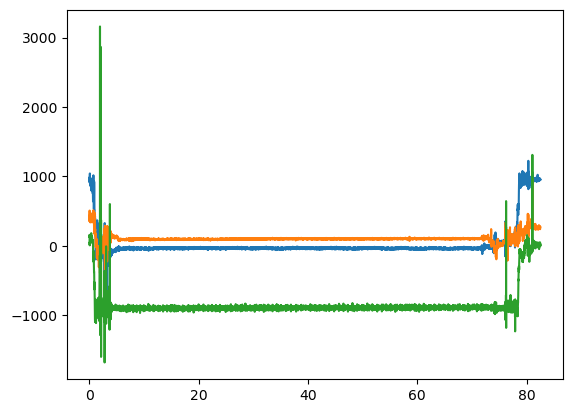

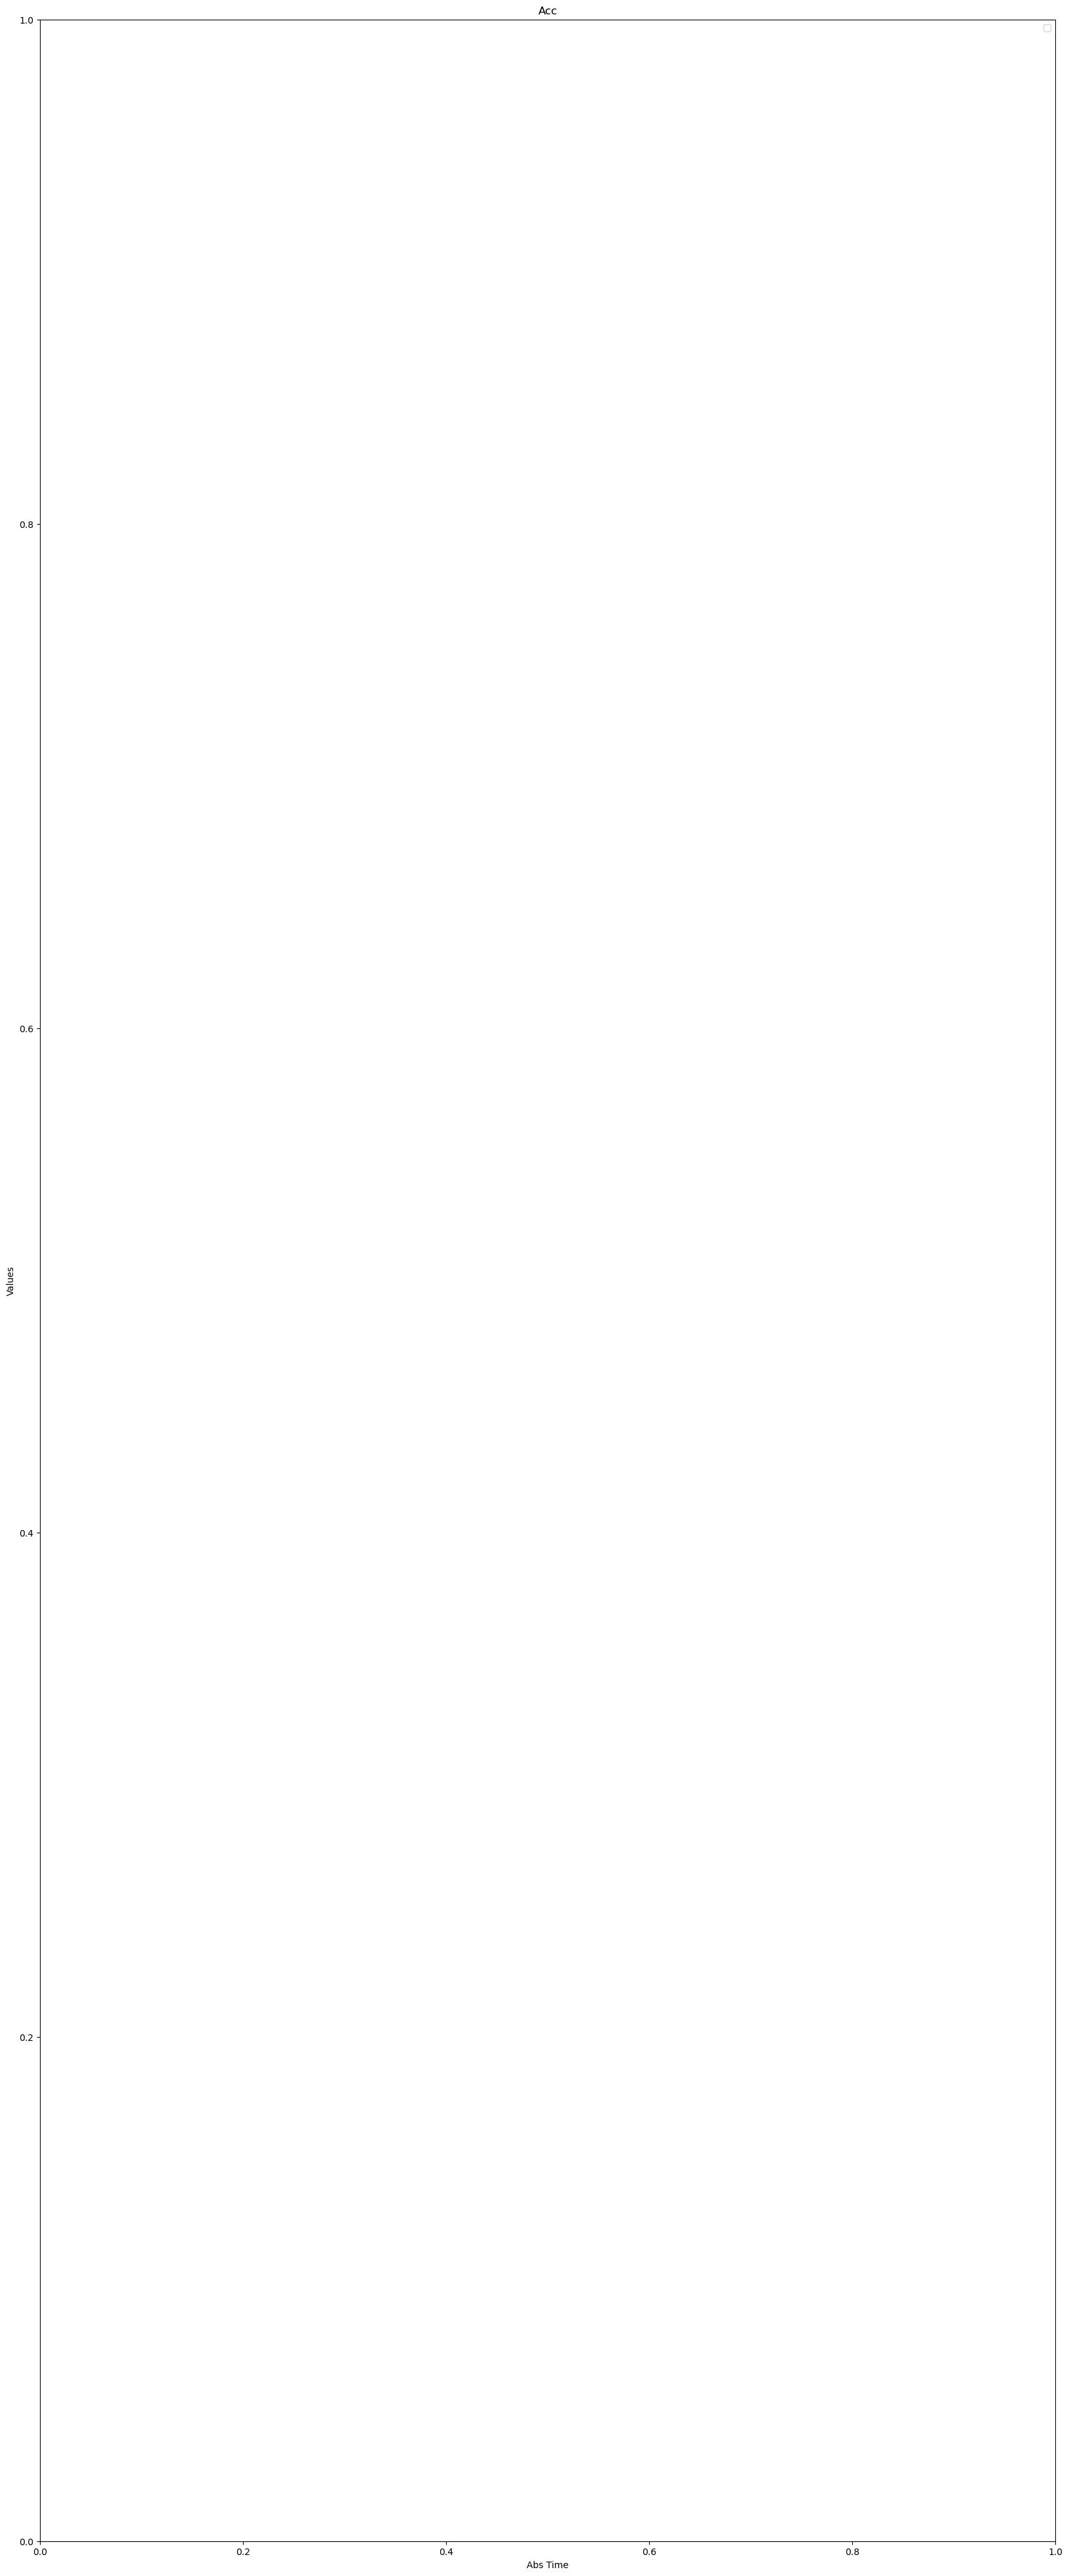

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


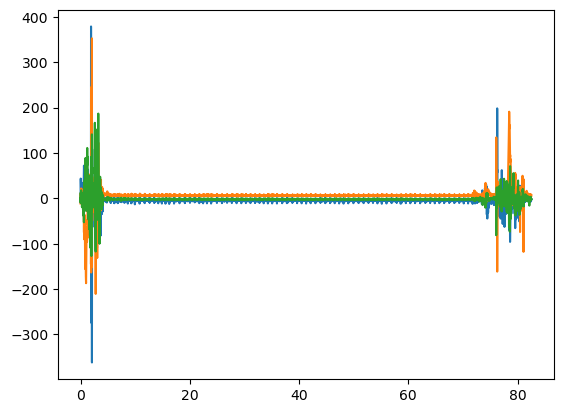

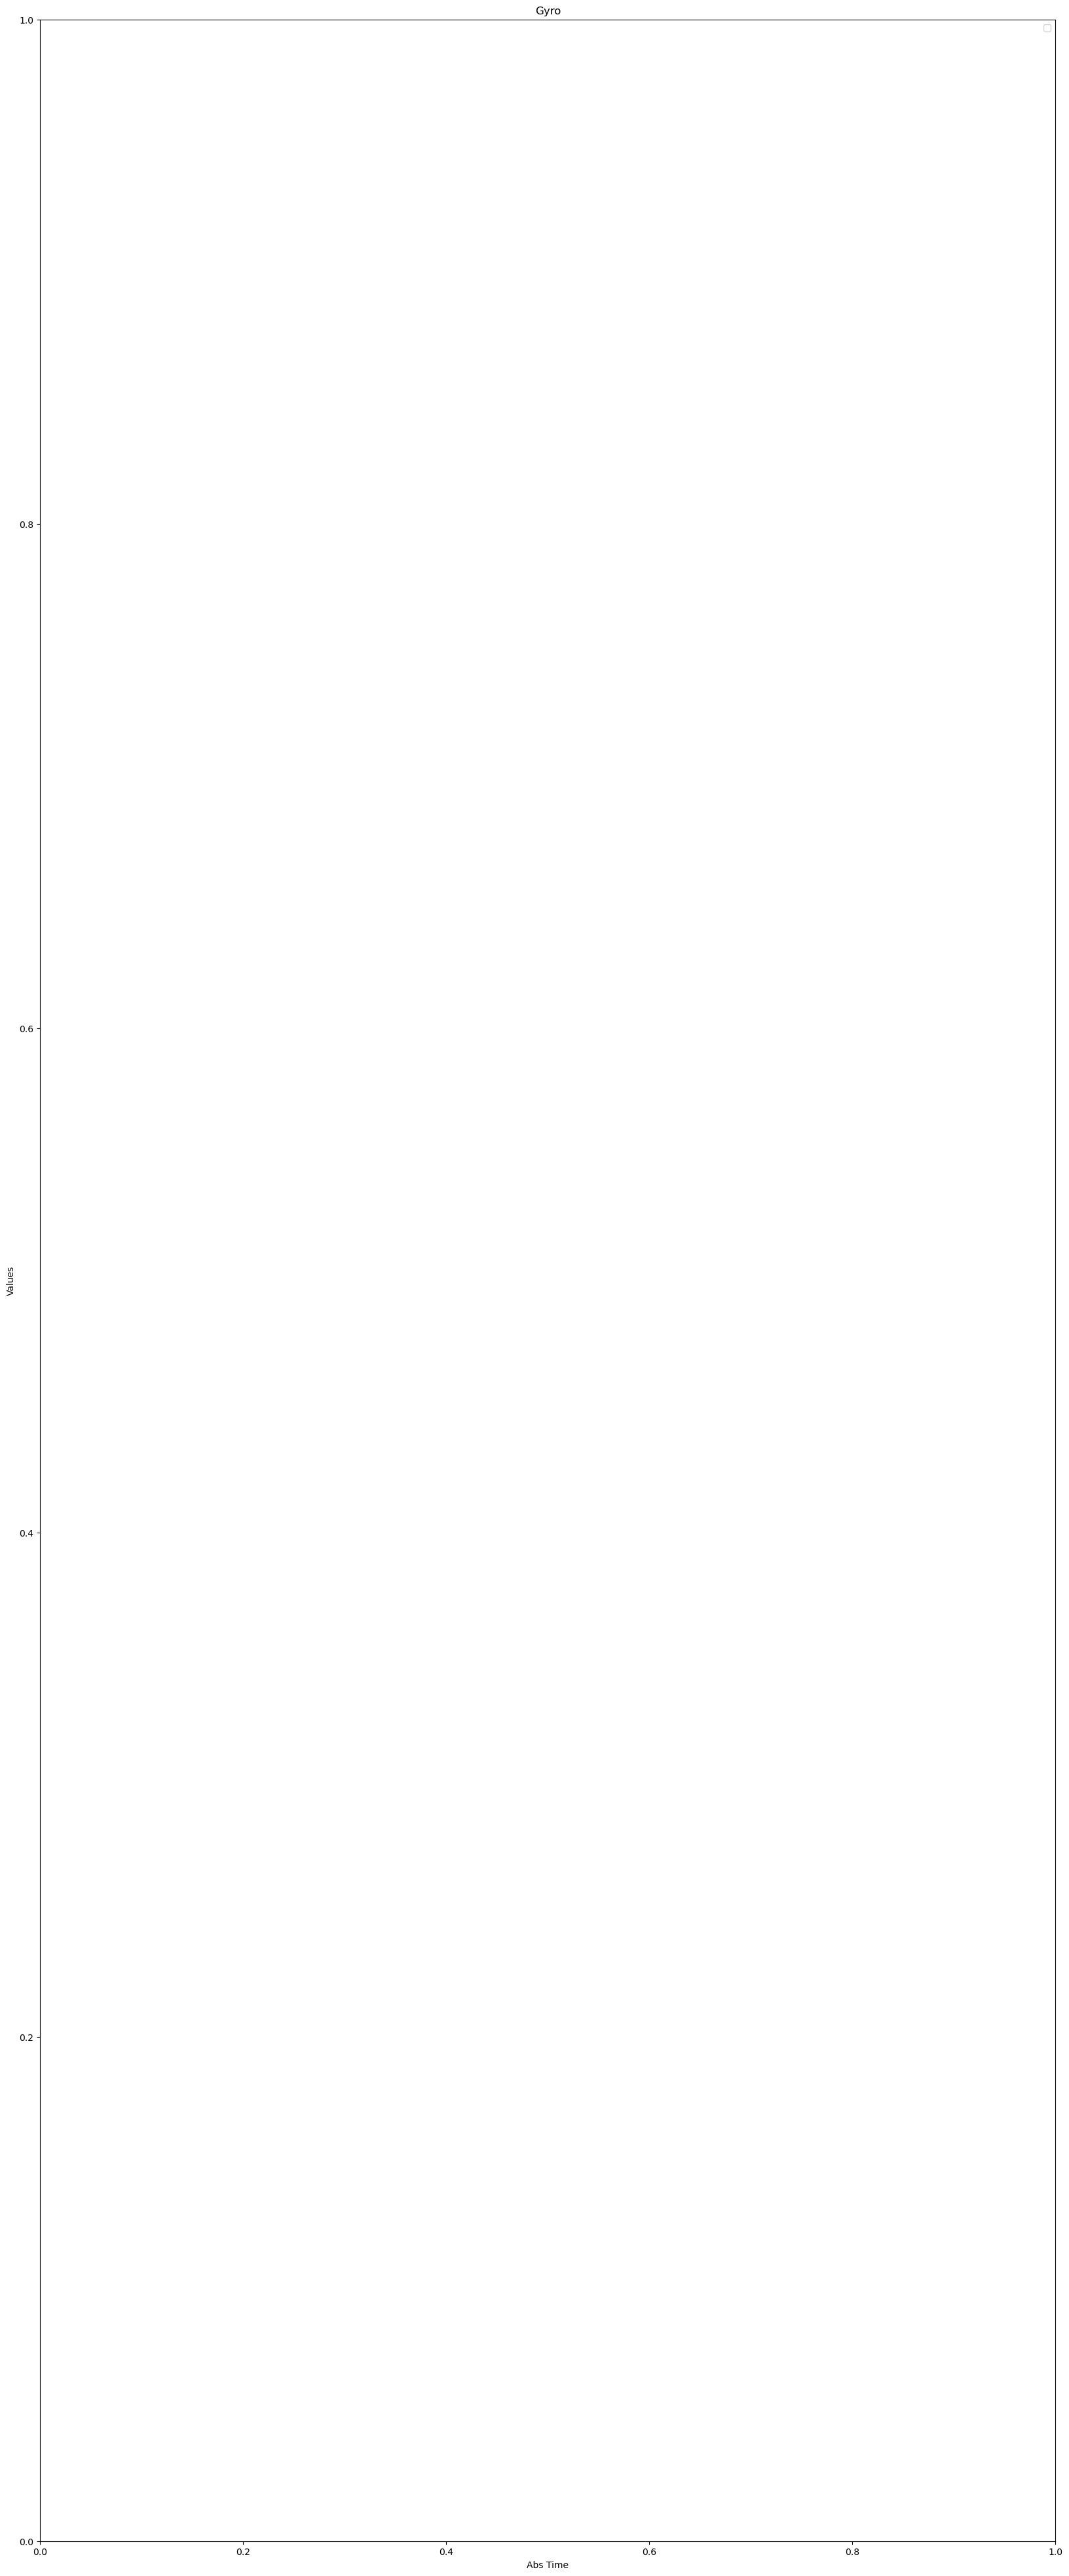

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


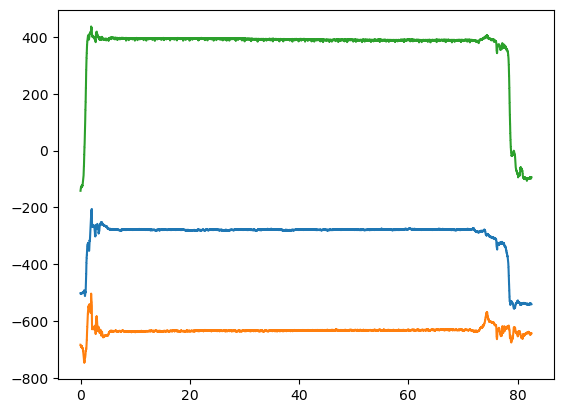

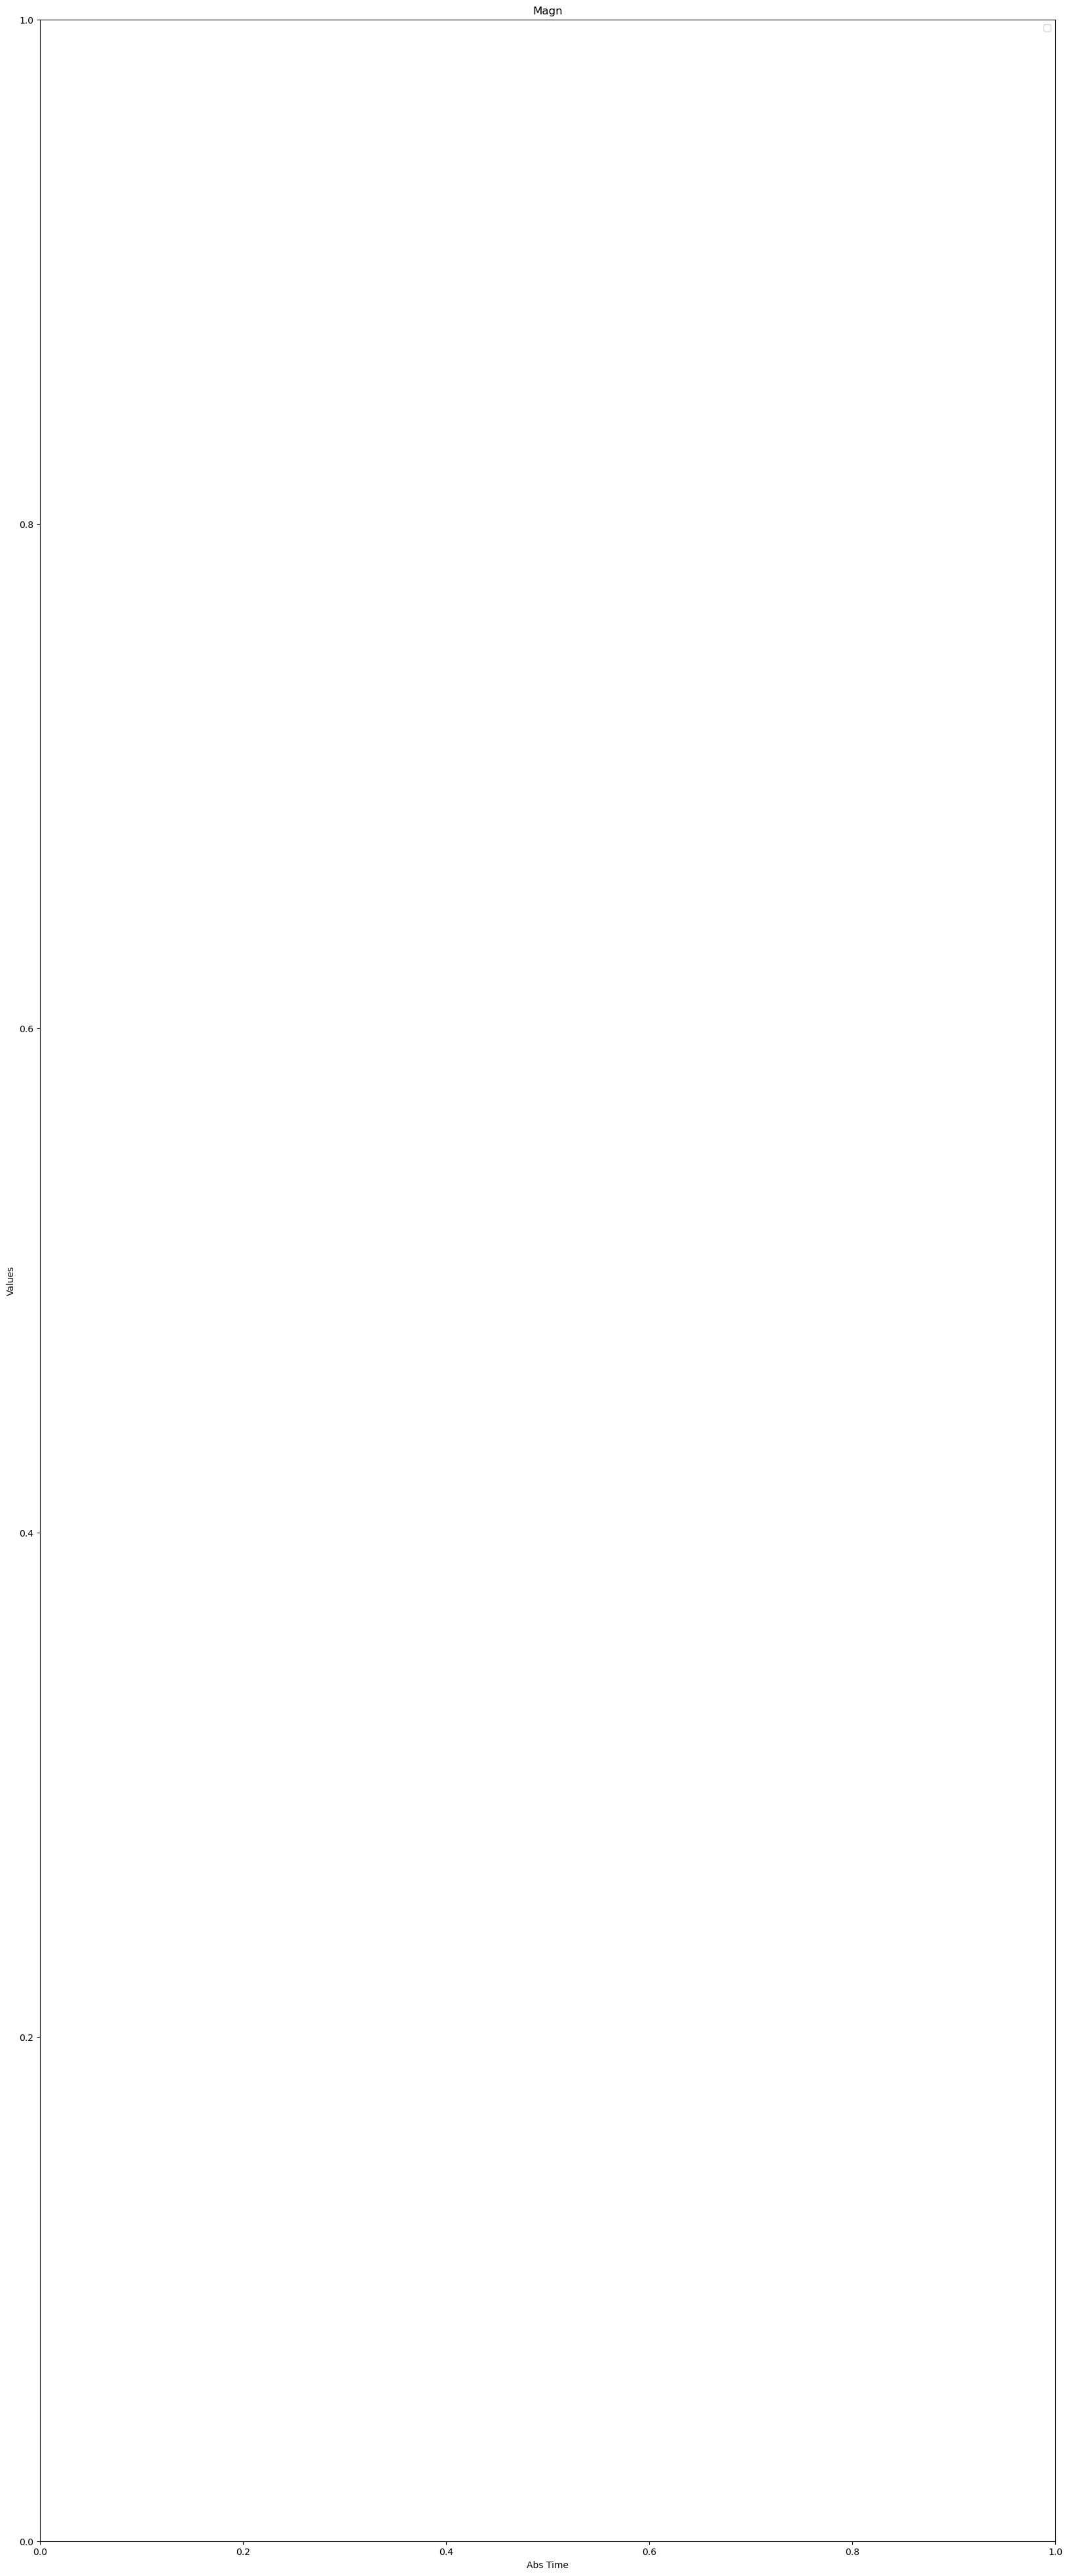

In [9]:
plot_data(df_selected, option=2)

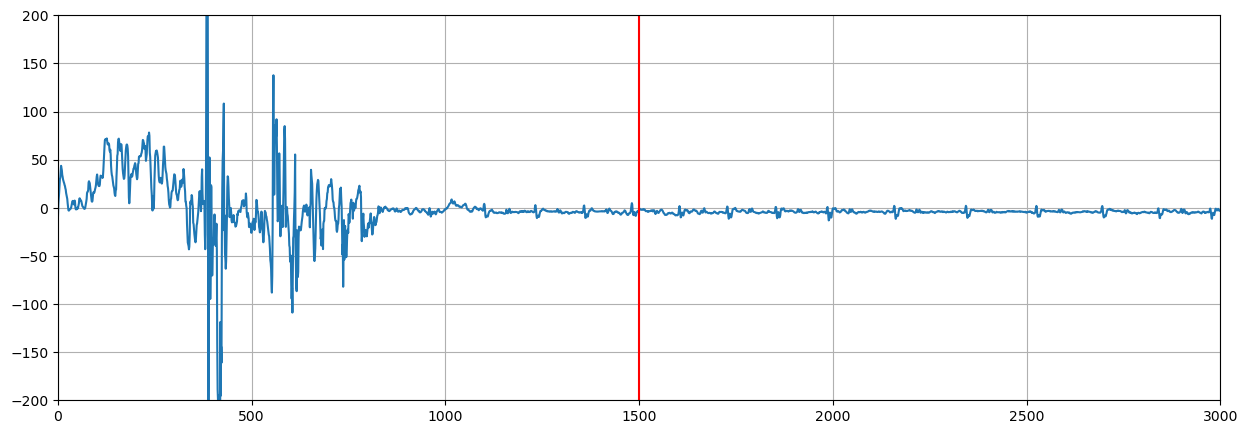

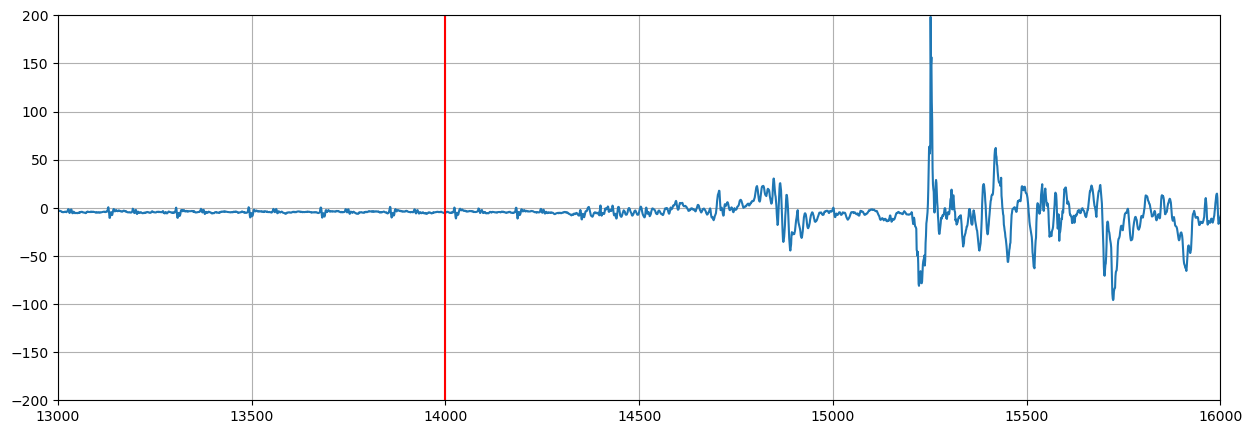

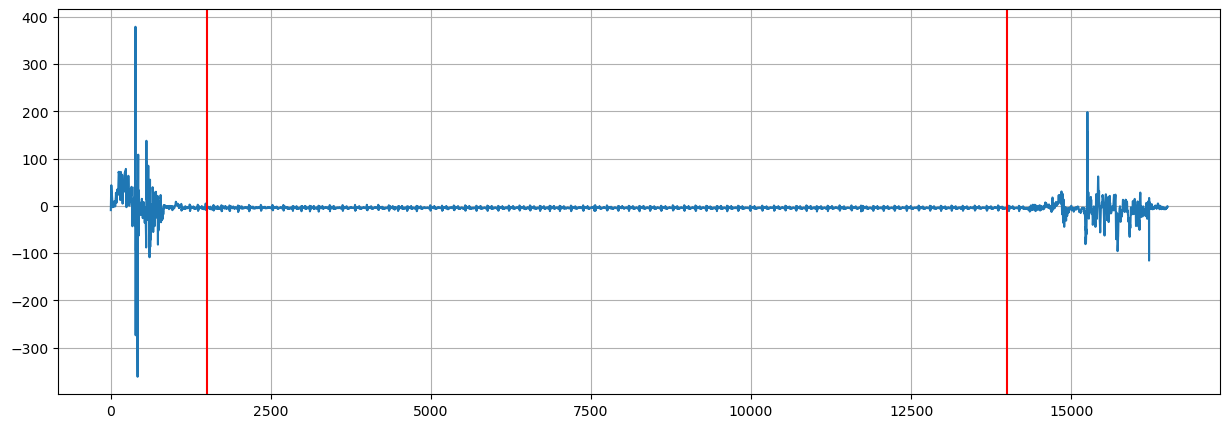

In [10]:
bounds = (1500, 14000)
plt.figure(figsize = (15,5))
plt.plot(np.arange(0,len(df_selected)), df_selected['GyroX'])
plt.axvline(x=bounds[0], color='red')
plt.xlim(0, 3000)
plt.ylim(-200,200)
plt.grid()
plt.show()

plt.figure(figsize = (15,5))
plt.plot(np.arange(0,len(df_selected)), df_selected['GyroX'])
plt.axvline(x=bounds[1], color='red')
plt.xlim(13000, 16000)
plt.ylim(-200,200)
plt.grid()
plt.show()

plt.figure(figsize = (15,5))
plt.plot(np.arange(0,len(df_selected)), df_selected['GyroX'])
plt.axvline(x=bounds[0], color='red')
plt.axvline(x=bounds[1], color='red')
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


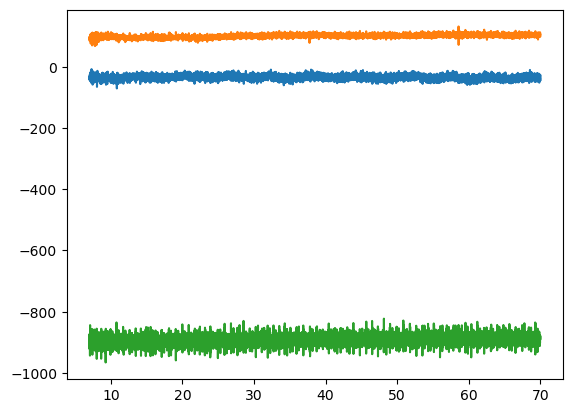

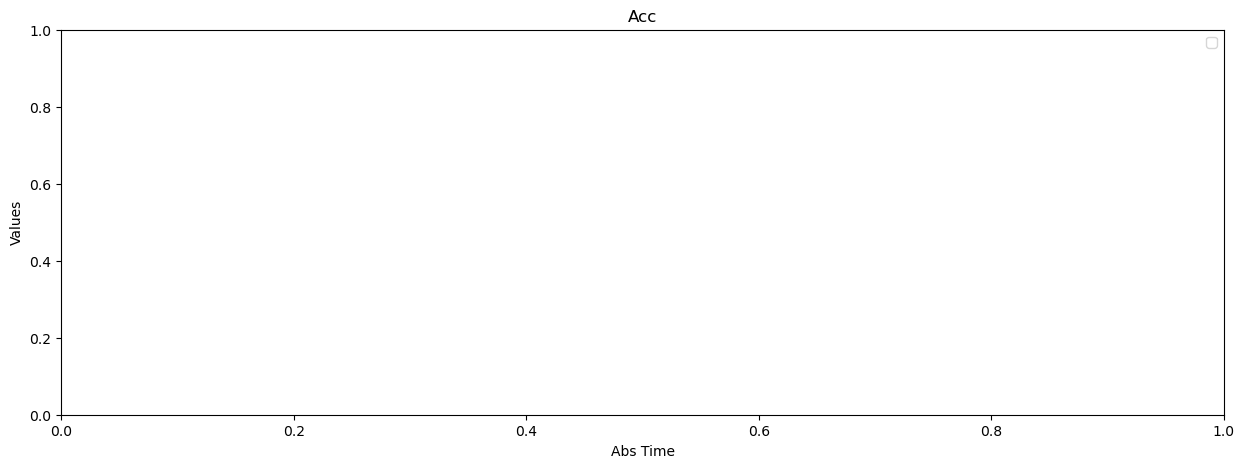

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


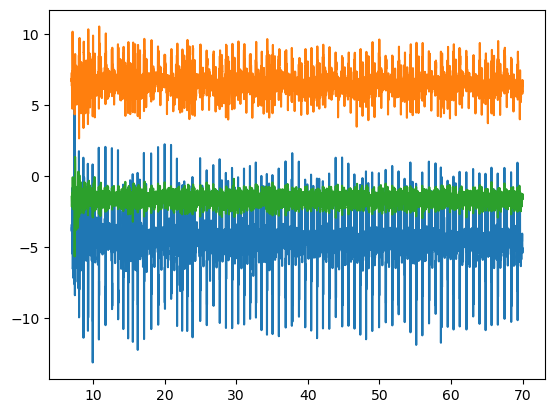

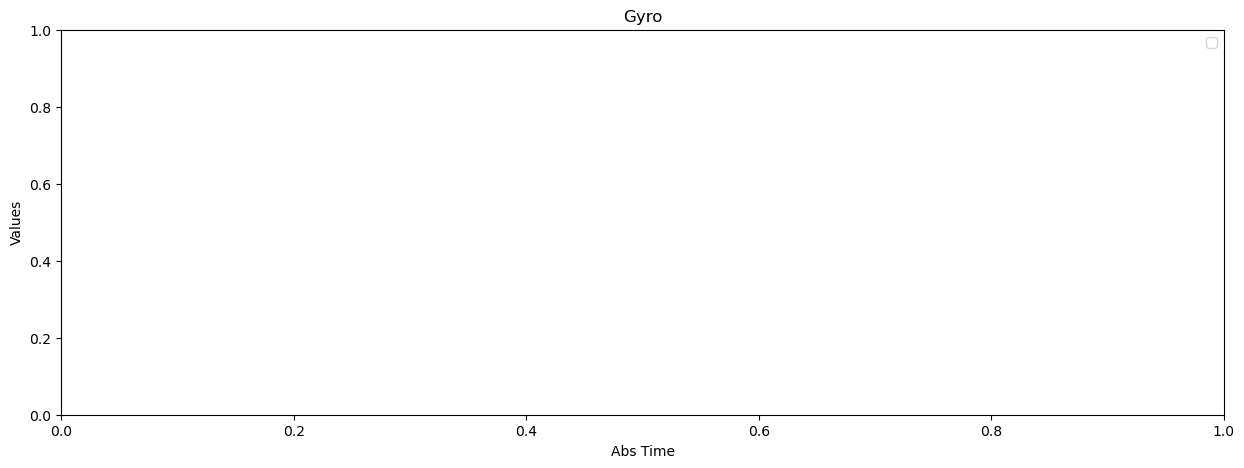

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


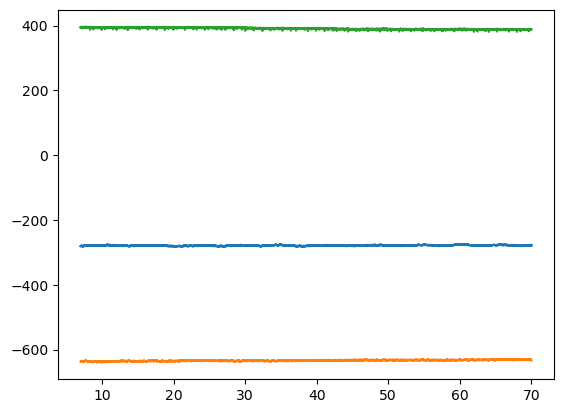

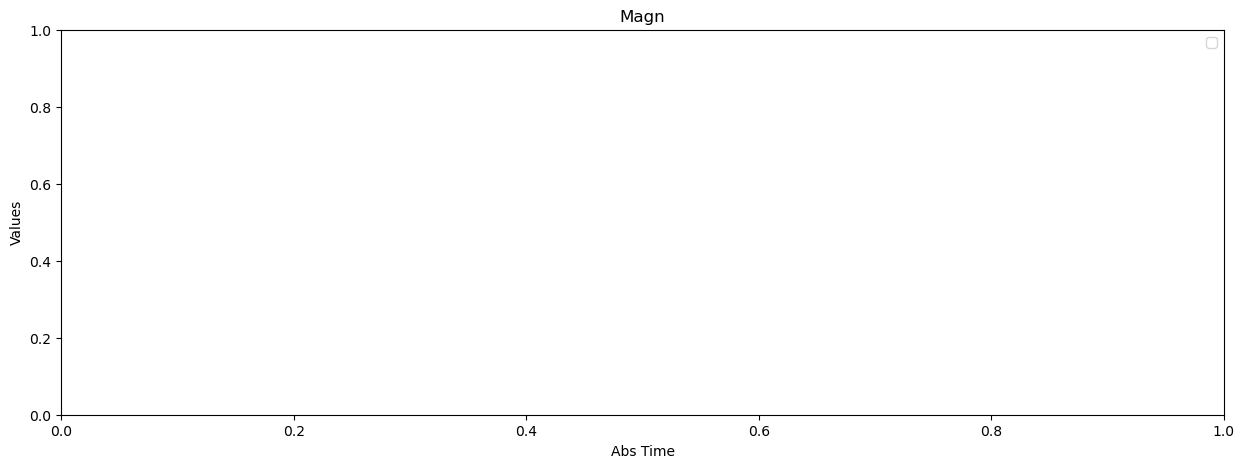

In [11]:
df_final = df_selected.iloc[1400:14000] 
Time = df_final['Abs Time']
df_proc = df_final.drop('Abs Time', axis =1)
plot_data(df_final, option = 2, fig_size= (15,5))

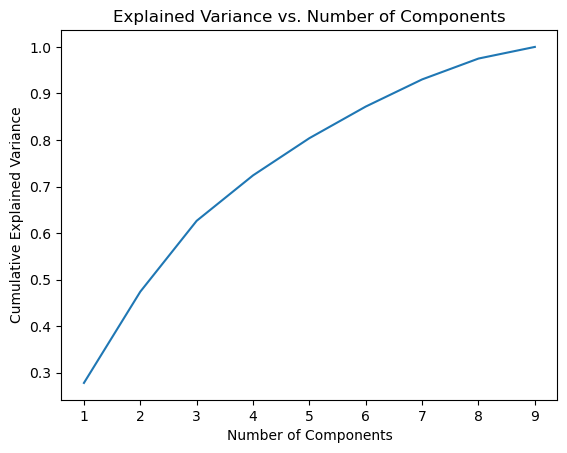

Number of components to explain 95.0% variance: 8


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_proc)
#df_scaled = df_proc
pca = PCA()
pca.fit(df_scaled)

# Plot the explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


threshold = 0.95

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Number of components to explain {threshold * 100}% variance: {num_components}")

In [14]:
n_components = 8
pca = PCA(n_components = n_components)
pca.fit(df_scaled)
df_PCA = pca.transform(df_scaled)

# 2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

Filter:

Implement your own filter, trying to extrapolate respiratory rate signal. Hint:

(a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

(b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

(c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal). (d) Find another method by yourselves.

Motivate your choice.


In [15]:
dt = df_o["Abs Time"].iloc[1] - df_o["Abs Time"].iloc[0]
print(dt)
df_final = df_selected.iloc[1400:14000]
T = df_final["Abs Time"].iloc[-1] - df_final["Abs Time"].iloc[0]
print(T)
time_filtered = df_final["Abs Time"] 
fs = 1/dt
f_samples = 1 / T

fNyq = 1/dt/2
print(fs)
print("THE NYQUIST FREQUENCY IS: ", fNyq)

0.005
62.995000000000005
200.0
THE NYQUIST FREQUENCY IS:  100.0


Text(0, 0.5, 'Amplitude')

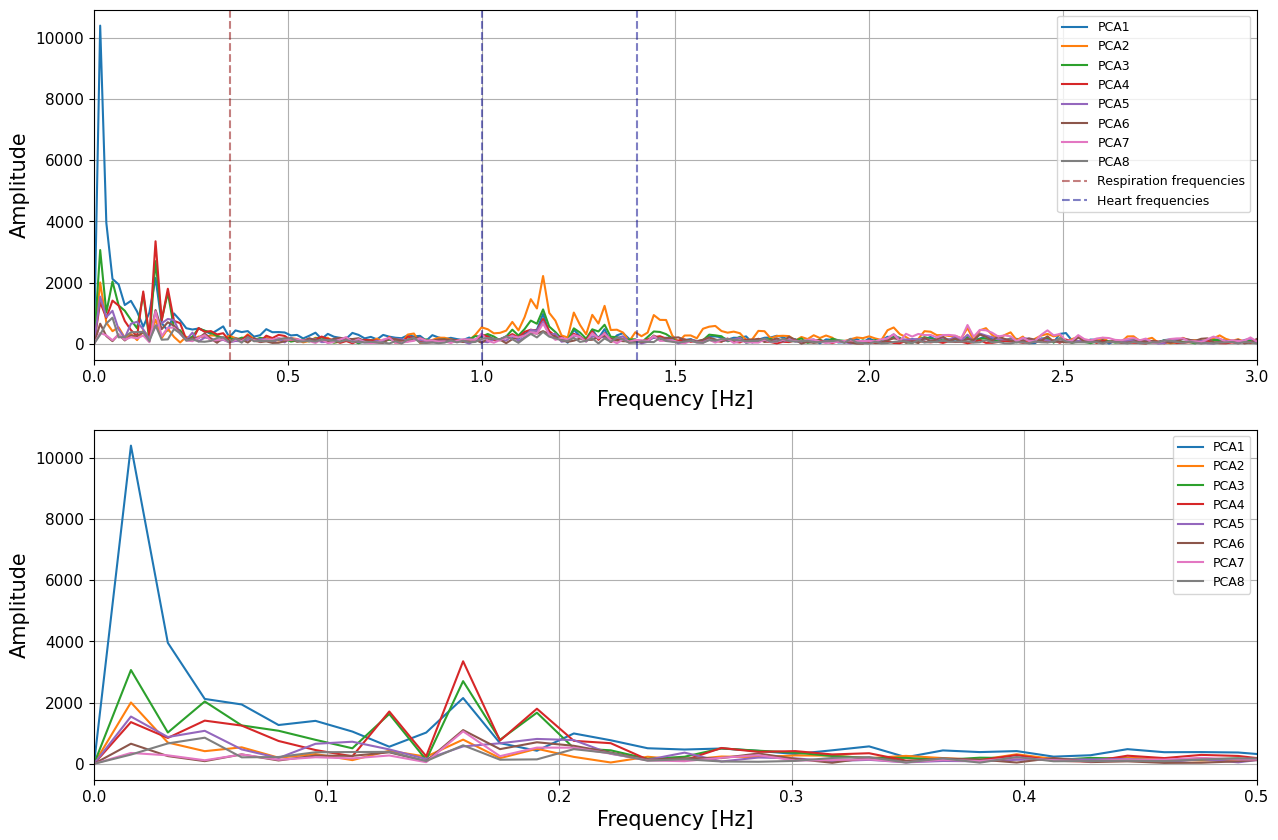

In [16]:
###### POWER SPECTRUM
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))
f_samples = 1/T
fNyq = 1/dt/2
f_axis = np.arange(0, fNyq, f_samples)
spectrum = []
N = len(df_PCA[:,0])
#frequencies = fftpack.fftshift(fftpack.fftfreq(N, d=T))
for i in range(0, df_PCA.shape[1]):
    s = fftpack.fft(df_PCA[:,i] - df_PCA[:,i].mean())
    s = np.abs(s)
    s = s[:int(len(df_PCA[:, i]) / 2)]
    ax[0].plot(f_axis, s, label = "PCA" + str(i+1))
    ax[1].plot(f_axis, s, label = "PCA" + str(i+1))
    spectrum.append(s)

ax[0].axvline(x = 0.35 , ls =  '--',color='darkred',label = "Respiration frequencies", alpha = 0.5)
ax[0].axvline(x = 1.0,ls =  '--', color = "darkblue", label = "Heart frequencies", alpha = 0.5)
ax[0].axvline(x = 1.4, ls =  '--',color = "darkblue", alpha = 0.5)
ax[0].legend(fontsize = 9)
ax[0].grid()
ax[0].set_xlim([0,3])
ax[0].tick_params(axis='both', labelsize=11)
ax[0].set_xlabel("Frequency [Hz]", fontsize = 15)
ax[0].set_ylabel("Amplitude", fontsize = 15)

ax[1].legend(fontsize = 9)
ax[1].grid()
ax[1].set_xlim([0,0.5])
ax[1].tick_params(axis='both', labelsize=11)
ax[1].set_xlabel("Frequency [Hz]", fontsize = 15)
ax[1].set_ylabel("Amplitude", fontsize = 15)
#ax[1].set_title("Spectrum with frequencies [0,0.5]Hz")

Clearly there is a peak around $f = [0.1, 0.4]Hz$ which is what we were expecting: the average respiratory rate in an adult is around $0.02 Hz$. So from now one a filter will be applied over those low frequencies in order to distinguish them from frequencies around $ [1,1.3] Hz$ which is the heart rate instead.

### SCIPY IMPLEMETED FILTER

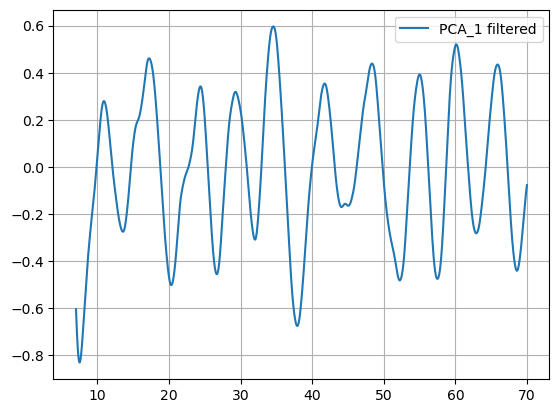

In [17]:
#first of all, let's apply low band-pass filter:

f_range = [0.05, 0.4] #those has to be expressed as Nyq fractions
b_low, a_low = signal.butter(2,f_range, "bandpass", fs = fs)
x_filt = signal.filtfilt(b_low, a_low, df_PCA[:,0], padlen = 150)
plt.plot(time_filtered, x_filt, label = "PCA_1 filtered")
plt.legend()
plt.grid()


Text(0, 0.5, 'Filtered signal')

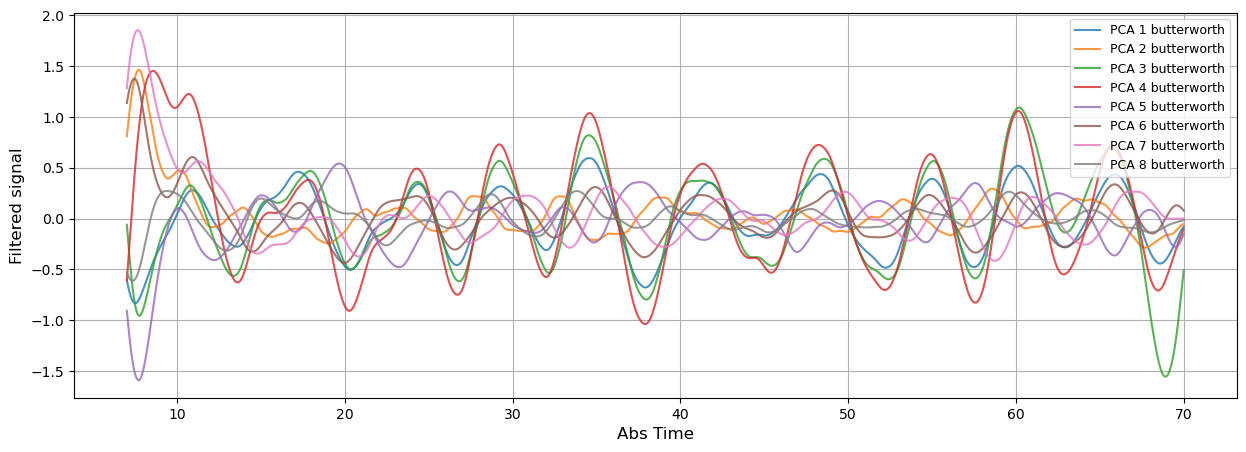

In [18]:
#now let's apply it to all the principal components
plt.figure(figsize = (15,5))
pca_fb = []
for i in range(0,df_PCA.shape[1]):
    f = signal.filtfilt(b_low, a_low, df_PCA[:,i], padlen = 150)
    plt.plot(time_filtered, f, label = "PCA " + str(i + 1) + " butterworth", alpha = 0.8)
    pca_fb.append(f)
plt.grid()
plt.legend(fontsize = 9)
plt.xlabel("Abs Time", fontsize = 12)
plt.ylabel("Filtered signal", fontsize = 12)

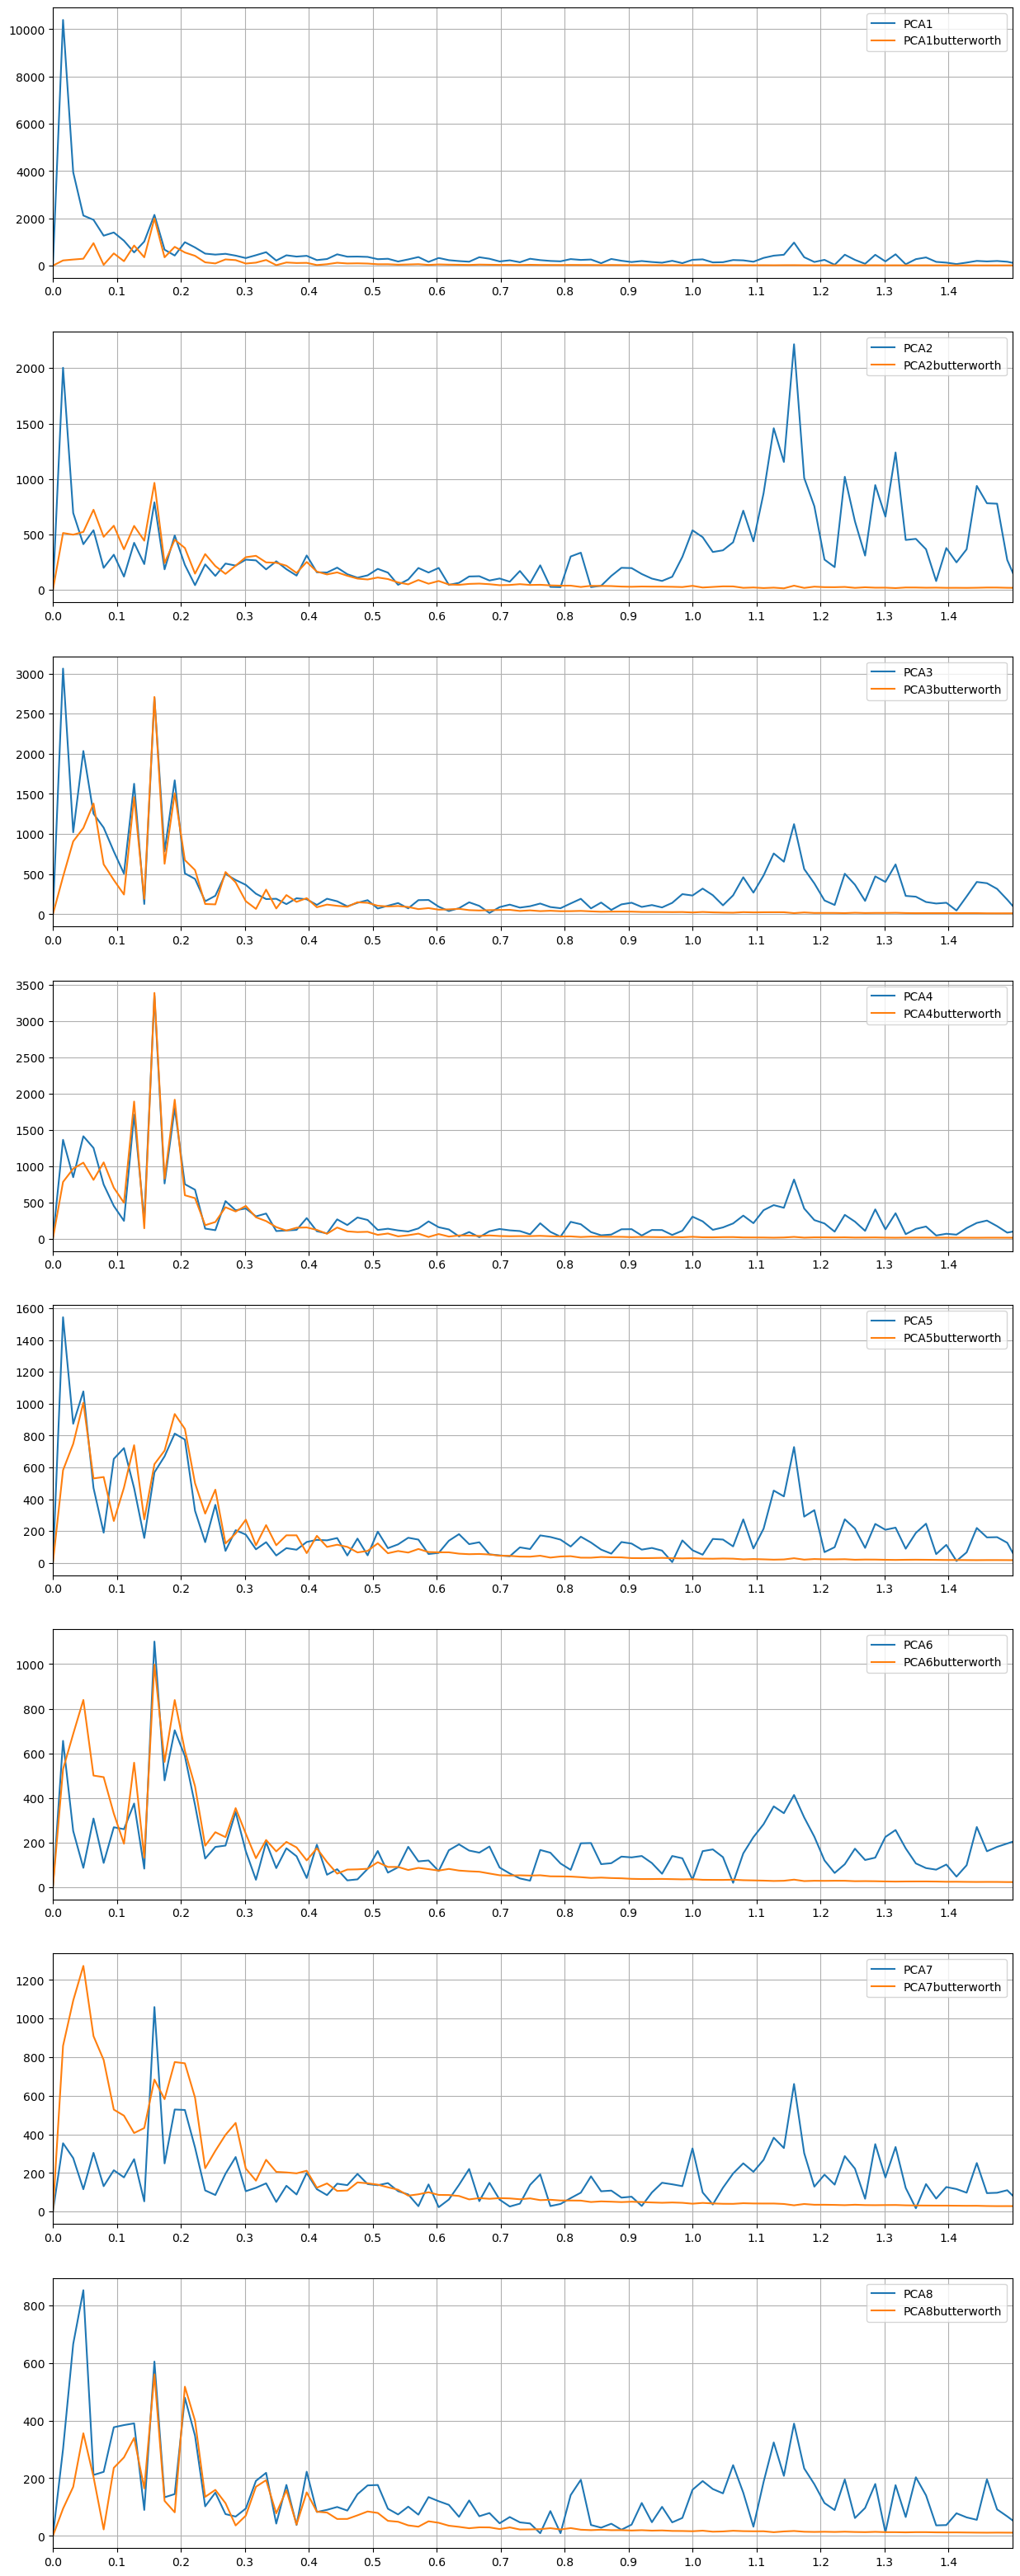

In [19]:
fig, ax = plt.subplots(nrows = 8, ncols = 1, figsize = (15,40))
#let's see the difference in the spectrum 
spect_bf = []
for i in range(0, df_PCA.shape[1]):
    s = fftpack.fft(pca_fb[i] - pca_fb[i].mean())
    s = np.abs(s)
    s = s[:int(len(pca_fb[i]) / 2)]
    ax[i].plot(f_axis, spectrum[i], label = "PCA" + str(i + 1))
    ax[i].plot(f_axis, s, label = "PCA" + str(i+1) + "butterworth")
    spect_bf.append(s)
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlim([0,1.5])
    ax[i].set_xticks(np.arange(0,1.5, 0.1))
    #ax[1].plot(f_axis, s, label = "PCA" + str(i+1))
    #spectrum.append(s)

## WAVELET

Now we try to use the wavelet filter

In [20]:
lev = pywt.dwt_max_level(len(df_PCA[:,1]), "sym5")
print(lev)
print("Range: ", (1/dt)/(2**(lev+1)), (1/dt)/(2**(lev - 1)))

10
Range:  0.09765625 0.390625


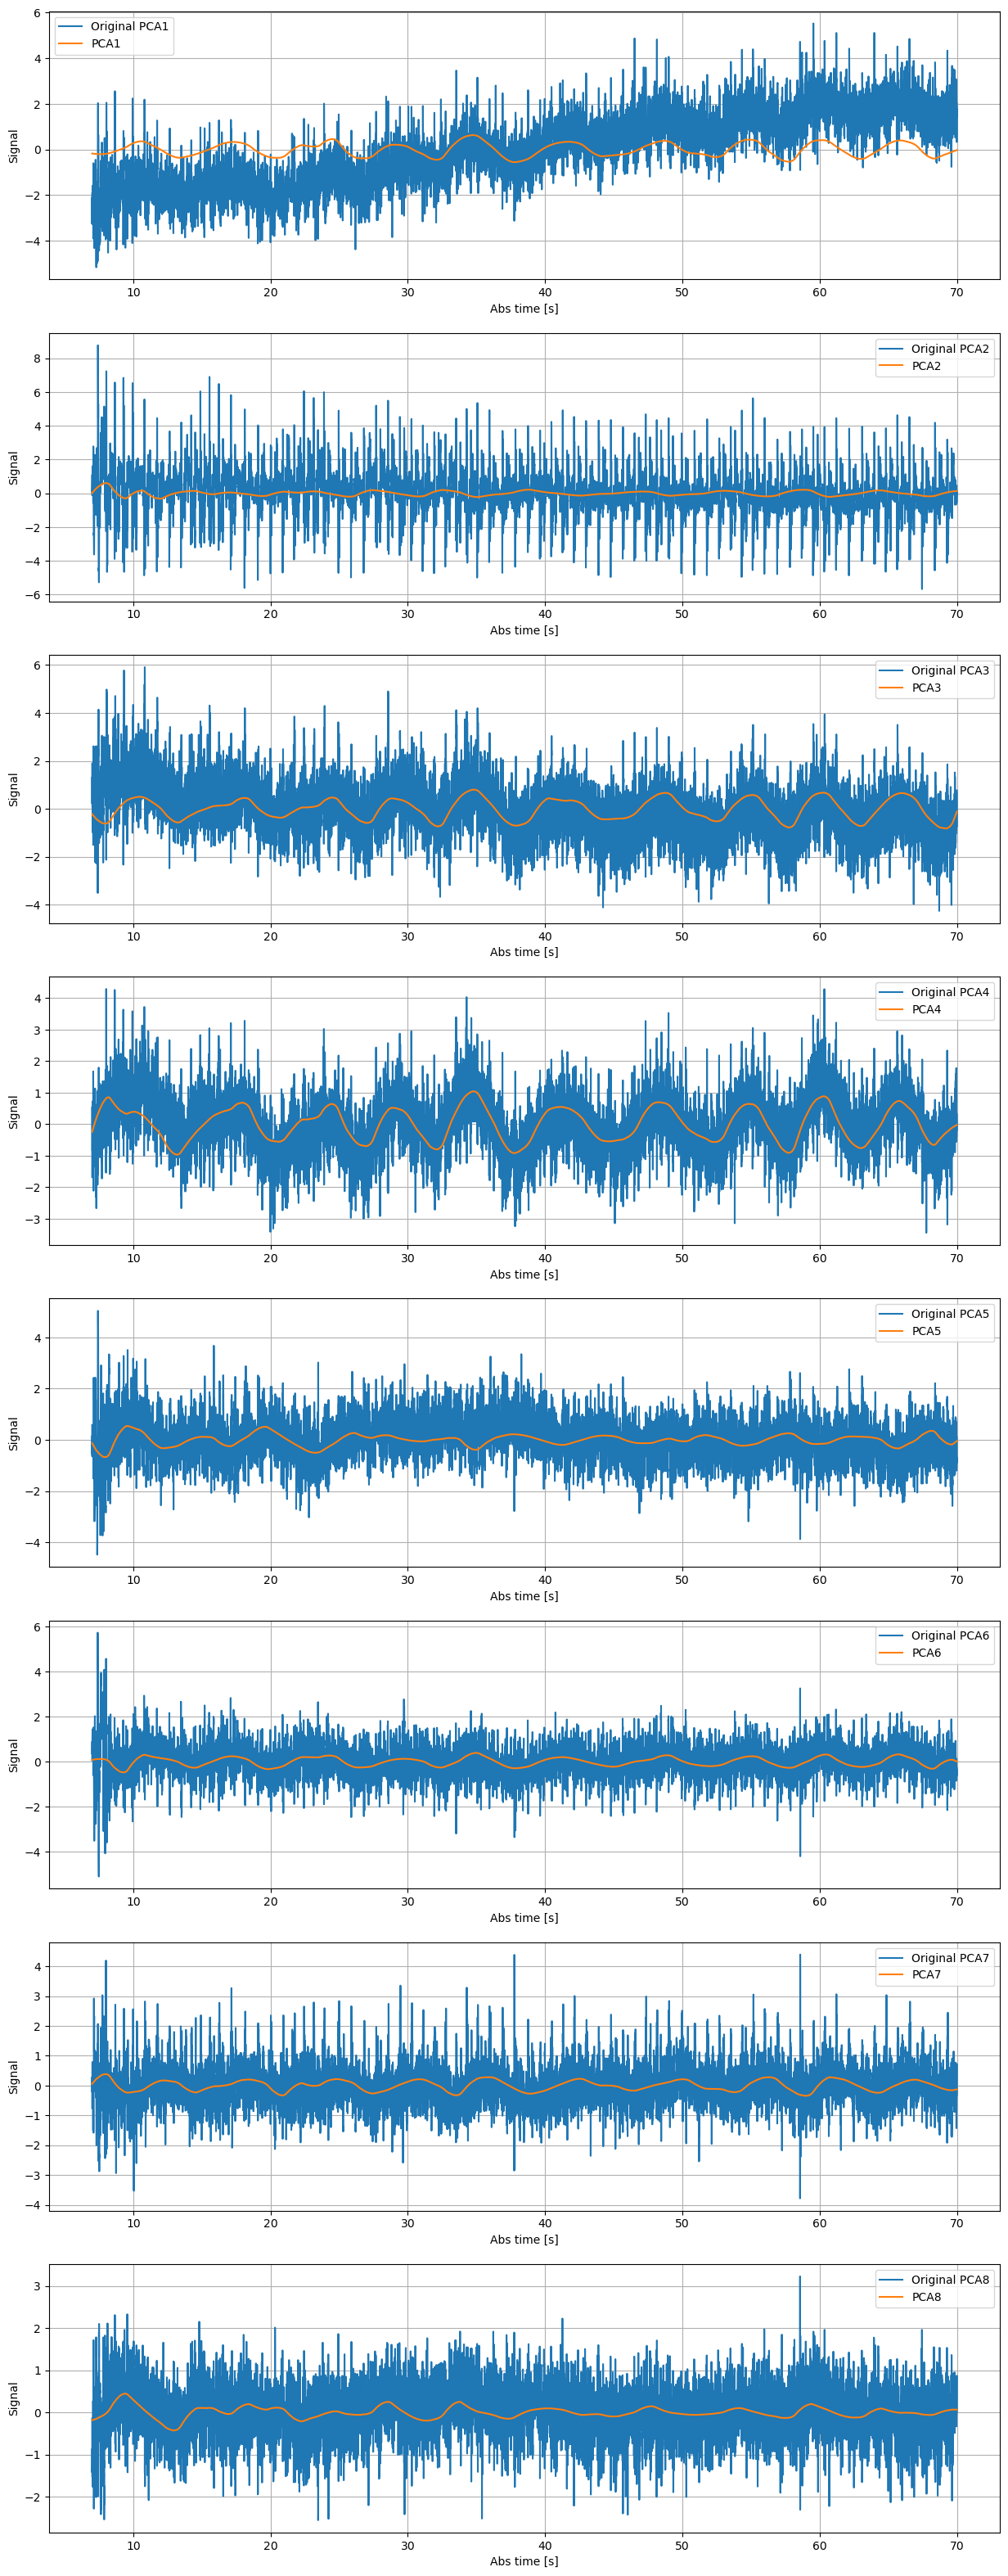

In [21]:
fig, ax = plt.subplots(nrows = df_PCA.shape[1], ncols = 1, figsize = (15, 40))
pca_wt = []
for i in range(0,df_PCA.shape[1]):
    coeffs = pywt.wavedec(df_PCA[:,i], wavelet = "sym5",mode= "constant", level = lev )
    coeffs[0] = np.zeros_like(coeffs[0])
    for j in range(3, lev + 1):
        coeffs[j] = np.zeros_like(coeffs[j])
    f_signal = pywt.waverec(coeffs, 'sym5')
    pca_wt.append(f_signal)
    ax[i].plot(time_filtered, df_PCA[:,i], label = "Original PCA" + str(i + 1))
    ax[i].plot(time_filtered, f_signal, label = "PCA" + str(i + 1))
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlabel("Abs time [s]")
    ax[i].set_ylabel("Signal")

In [22]:
#decomposizione su diverse frequenze:[2**(-j), 2**(-(j+1))]
coeffs = pywt.wavedec(df_PCA[:,7], wavelet = "sym5",mode= "constant", level = lev )

#devo mettere a zero tutte le frequenze a cui non sono interessata, in pratica salvo solo j = 9 j = 10
coeffs[0] = np.zeros_like(coeffs[0])
for i in range(3, 11):
    coeffs[i] = np.zeros_like(coeffs[i])

f_signal = pywt.waverec(coeffs, 'sym5')


In [23]:
coeffs = pywt.wavedec(df_PCA[:,7], wavelet = "db6",mode= "constant", level = lev )

#devo mettere a zero tutte le frequenze a cui non sono interessata, in pratica salvo solo j = 9 j = 10
coeffs[0] = np.zeros_like(coeffs[0])
for i in range(3, 11):
    coeffs[i] = np.zeros_like(coeffs[i])

f_signal1 = pywt.waverec(coeffs, 'db6')

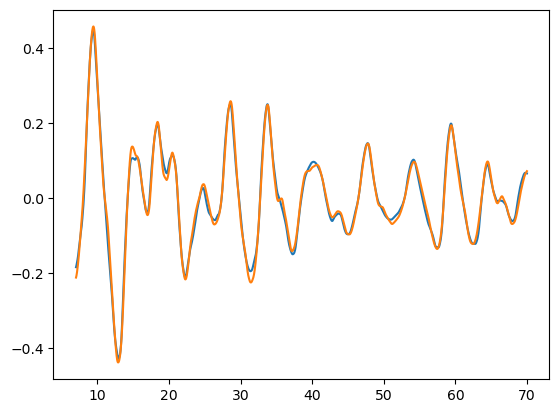

In [24]:
plt.plot(time_filtered, f_signal)
plt.plot(time_filtered, f_signal1)


## RICORDATI DI CAPIRE LE DIVERSE TIPOLOGIE DI FAMIGLIE DI DECOMPOSIZIONE WAVELET (ZERO CAPITE)


PEAK DETECTION, POI PUOI MANDARE A VITT

## PEAK DETECTION

In [25]:
###### CHOOSE THE METHOD #####
filter = "Wavelet"

if filter == "Butterworth":
    p_signal = pca_fb
else: p_signal = pca_wt

time_filtered = np.array(time_filtered)

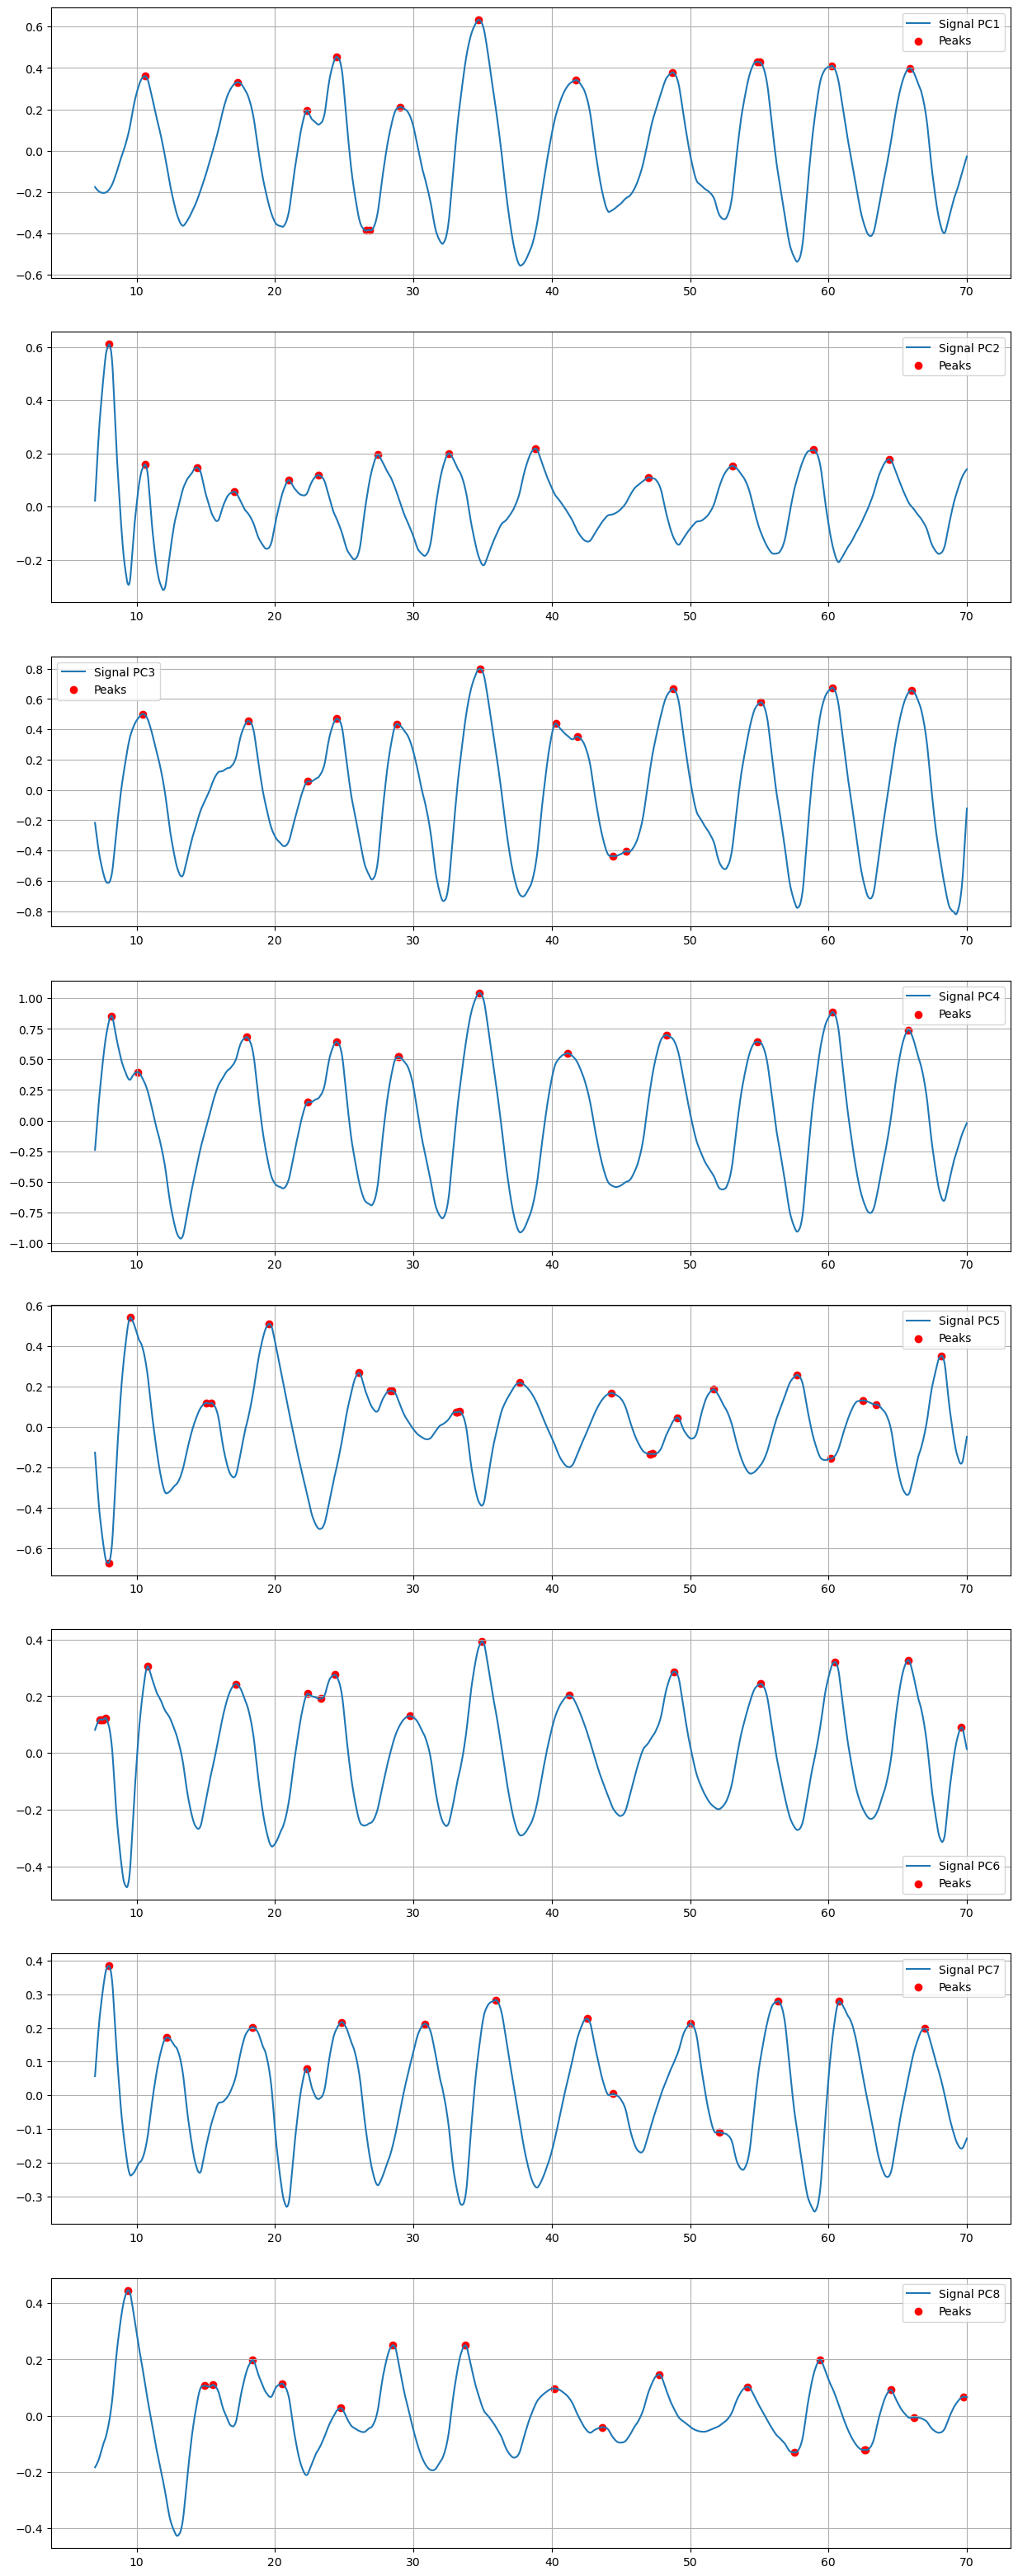

In [26]:
fig, ax = plt.subplots(nrows = df_PCA.shape[1], ncols = 1, figsize = (15, 40))
peaks = []
for i in range(df_PCA.shape[1]):
    p_s = p_signal[i]
    p, _ = signal.find_peaks(p_s)
    ax[i].plot(time_filtered, p_s, label = "Signal PC" + str(i + 1))
    ax[i].scatter(time_filtered[p], p_s[p], color = "red", label = "Peaks")
    peaks.append(p)
    ax[i].legend()
    ax[i].grid()

In [122]:
### OKAY VA DECISAMENTE MIGLIORATO!!!!!
p_s = p_signal[1]
peaks, properties = signal.find_peaks(p_s, height = [0, 1], distance = 300) 

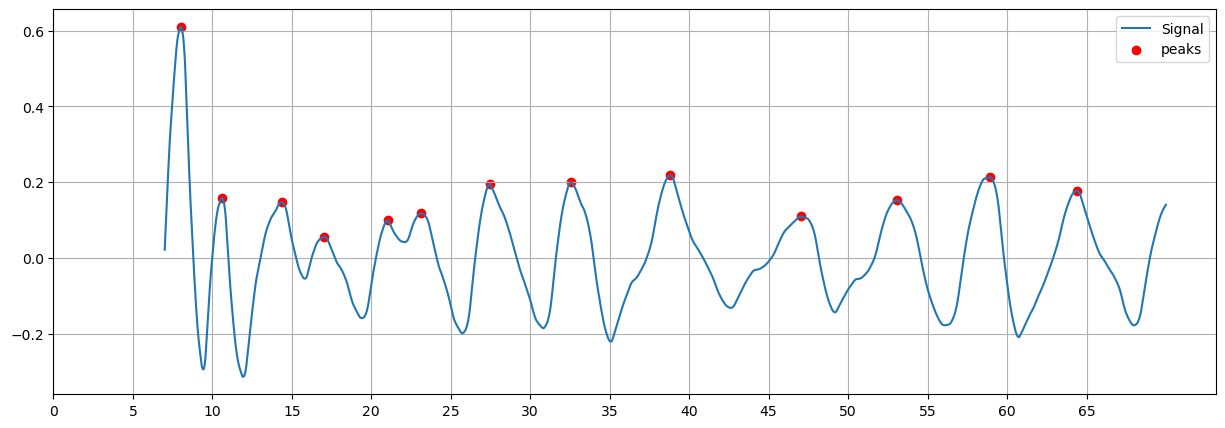

In [123]:
#VERSIONE MIGLIORATA DI QUELLO SOPRA
plt.figure(figsize = (15,5))
plt.plot(time_filtered, p_s, label = "Signal")
plt.scatter(time_filtered[peaks], p_s[peaks], color = "red", label = "peaks")
plt.xticks(np.arange(0,70,5))
plt.legend()
plt.grid()

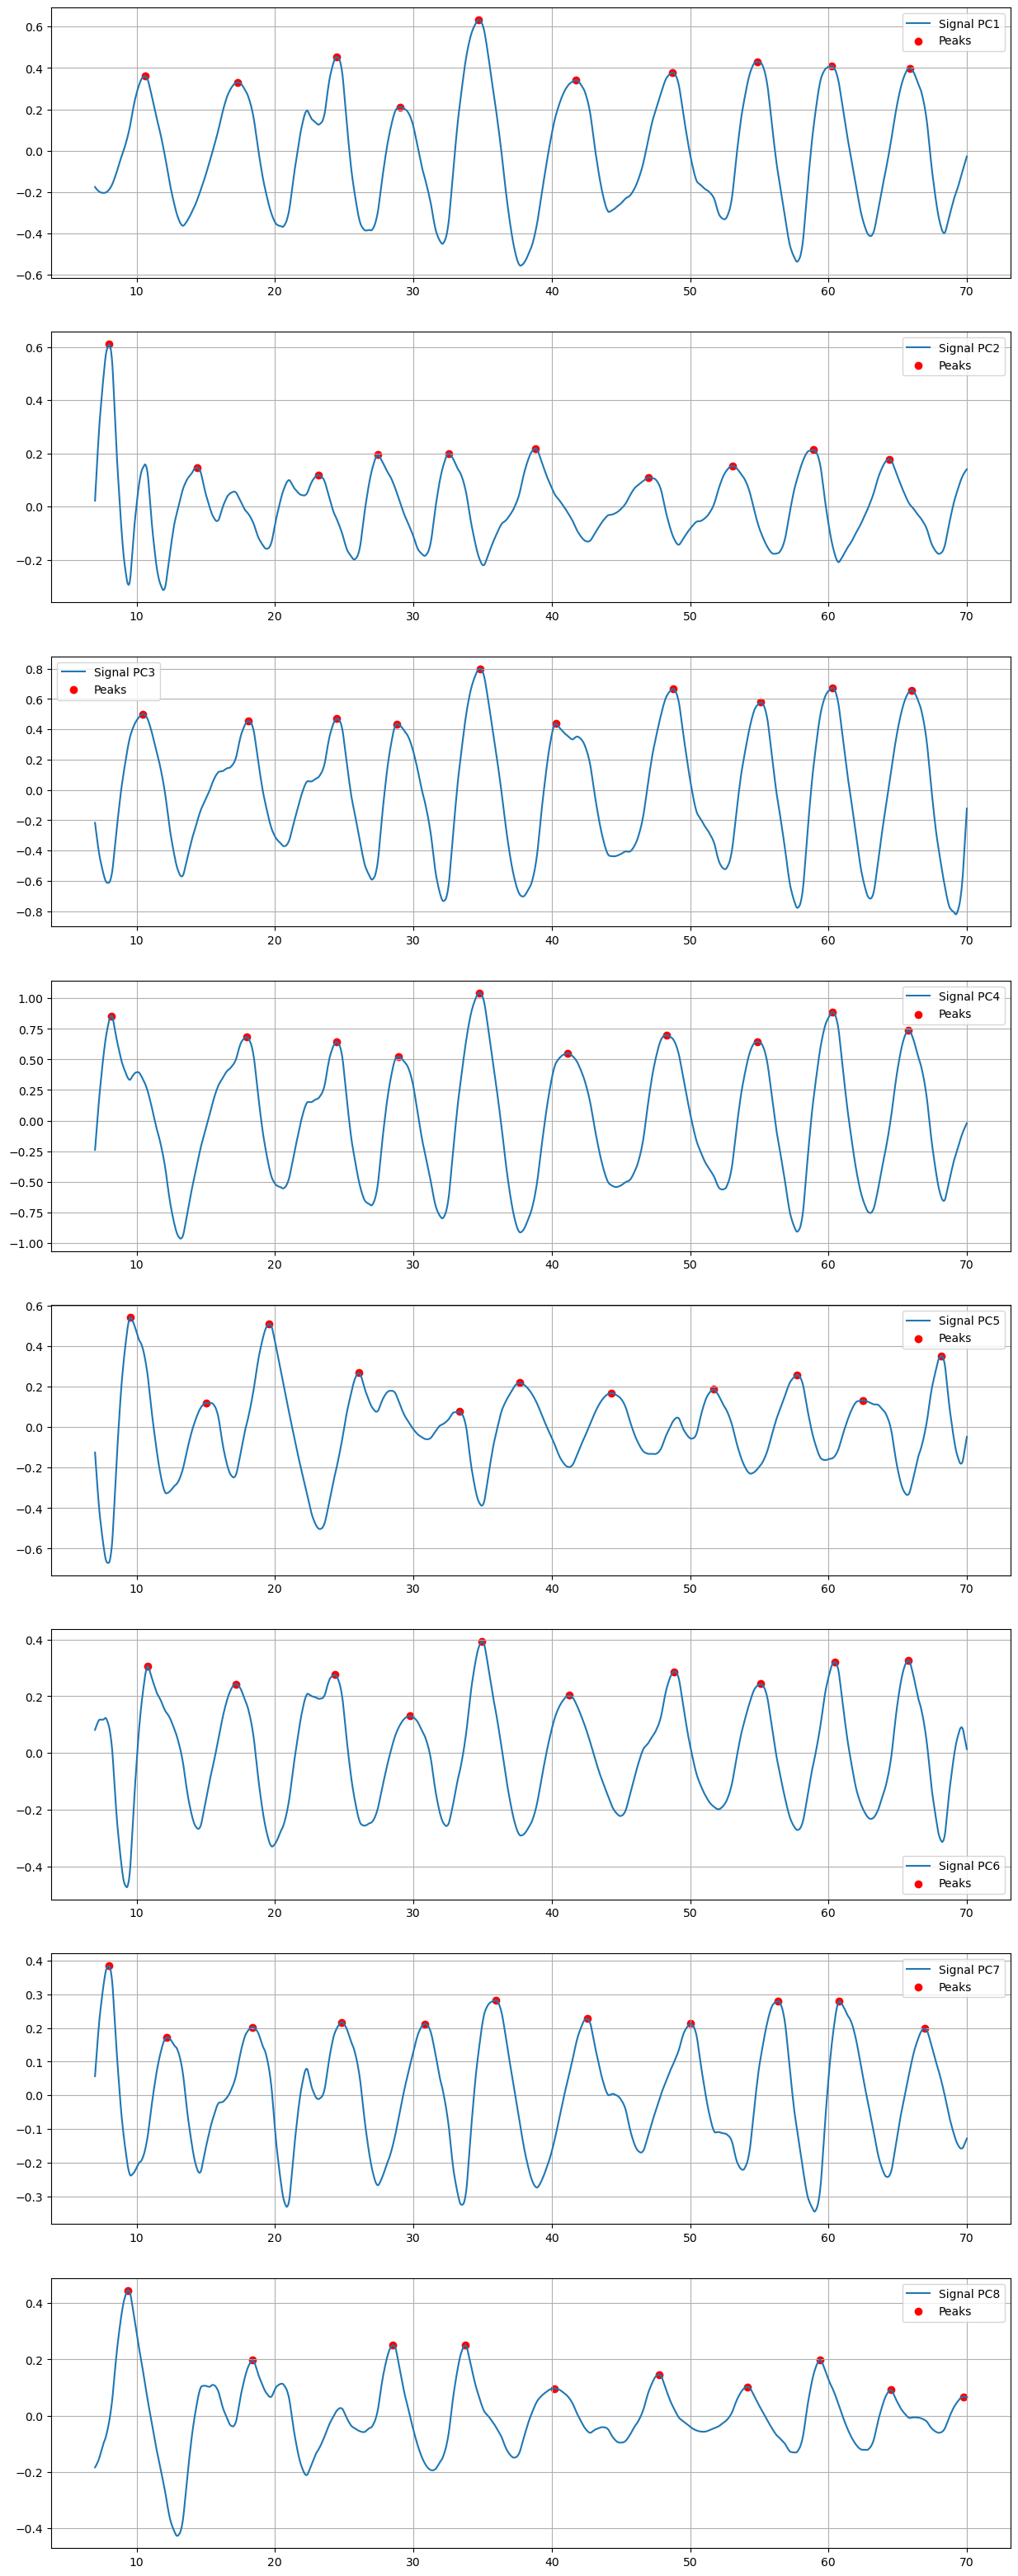

In [124]:
fig, ax = plt.subplots(nrows = df_PCA.shape[1], ncols = 1, figsize = (15, 40))
peaks_new = []
for i in range(df_PCA.shape[1]):
    p_s = p_signal[i]
    p, _ = signal.find_peaks(p_s,height = [0, 4], distance = 800)
    ax[i].plot(time_filtered, p_s, label = "Signal PC" + str(i + 1))
    ax[i].scatter(time_filtered[p], p_s[p], color = "red", label = "Peaks")
    peaks_new.append(p)
    ax[i].legend()
    ax[i].grid()

# 4.1. Respiratory Rate Per Minute(RPM)

Fit parameters (Amplitude, Mean, Sigma):	 [2.73941111 5.81315841 0.81354081]
Fit parameters errors (Amplitude, Mean, Sigma):	 [0.88813625 0.30409083 0.31478087]
The estimated Respiratory Period is 5.81 s, corresponding to a Respiratory Rate of 0 2 Hz, i.e. approximately 10.32 breaths per minute.


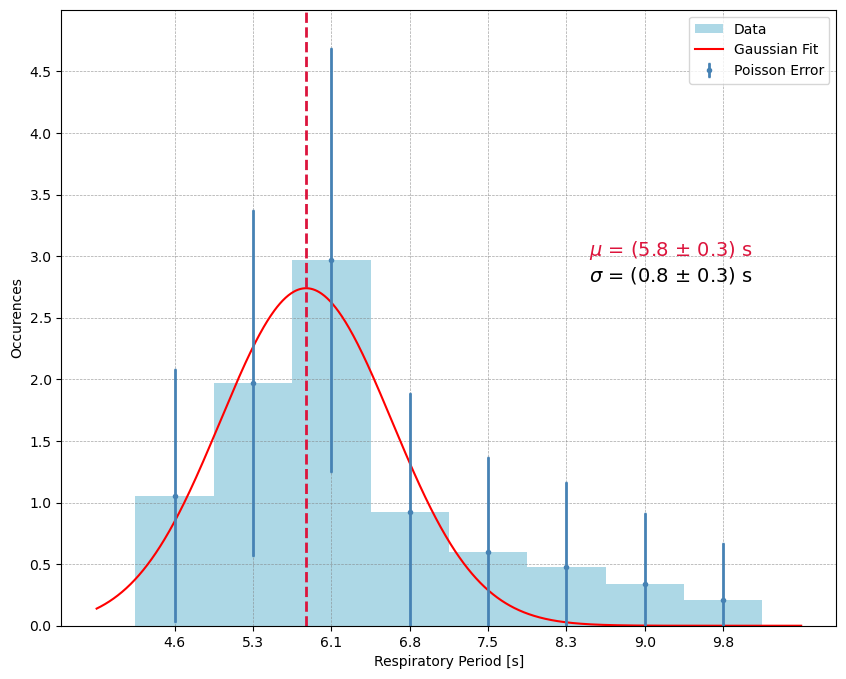

In [253]:
from scipy import optimize

time_dist = []
for i in range(1, len(peaks_new)):
    temp_time_dist = []    
    for j in range(1, len(peaks_new[i])):
        temp_peaks_time = time_filtered[peaks_new[i]]
        temp_time_dist.append(temp_peaks_time[j]-temp_peaks_time[j-1])
    time_dist.append(temp_time_dist)

avls, avts = np.linalg.eig(np.cov(df_scaled.T))
sort_perm = np.flip(np.argsort(avls))

avls = np.real_if_close(avls[sort_perm])
avts = avts[:, sort_perm]

var_ratios = avls / np.sum(avls)

weights = [[var_ratios[i] for j in range(len(time_dist[i]))] for i in range(7)]

time_dist_total = np.concatenate(time_dist)
weights_total = np.concatenate(weights)
      
fig, ax = plt.subplots(figsize=(10,8))
bins = ax.hist(x=time_dist_total, bins=round(np.sqrt(len(time_dist_total))),label="Data",weights=weights_total,  facecolor='lightblue')

bin_centers=[(bins[1][i]+bins[1][i+1])/2 for i in range(len(bins[1])-1)]
bin_counts = bins[0]
bin_width = round(bins[1][1]-bins[1][0], 2)

ax.set_xticks(bin_centers)
ax.set_xticklabels(map(lambda x: round(x,1),bin_centers))
ax.set_yticks(np.arange(0.0,5.0,0.5))
ax.set_ylim(0.0,5.0)

def gaus(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x-mu)/sigma) ** 2)

params, params_cov = optimize.curve_fit(gaus, bin_centers, bin_counts, absolute_sigma=True)
#fit_domain = np.sort(np.random.uniform(np.min(bin_centers), np.max(bin_centers), 1000))

px=np.linspace(np.min(bin_centers)-bin_width,np.max(bin_centers)+bin_width,1000)

ax.plot(px, my_gaus(px, *params), label="Gaussian Fit", color='r')
ax.set_xlabel("Respiratory Period [s]")
ax.set_ylabel("Occurences")
errors = np.sqrt(bins[0])
ax.errorbar(x=bin_centers, y=bins[0], yerr=errors, fmt='.', capsize=1, color='steelblue', elinewidth=2, label="Poisson Error")

ax.text(8.5, 3, f'$\mu$ = ({params[1]:.1f} $\pm$ {np.sqrt(np.diag(params_cov)[1]):.1f}) s' , fontsize = 14, color='crimson')
ax.text(8.5, 2.8,f'\n$\sigma$ = ({params[2]:.1f} $\pm$ {np.sqrt(np.diag(params_cov)[2]):.1f}) s', fontsize = 14)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

ax.axvline(params[1], linestyle='dashed', linewidth=2,color='crimson')
ax.legend(loc='best')

print('Fit parameters (Amplitude, Mean, Sigma):\t', params)
print('Fit parameters errors (Amplitude, Mean, Sigma):\t', np.sqrt(np.diag(params_cov)))
print('The estimated Respiratory Period is', round(params[1],2),'s, corresponding to a Respiratory Rate of', round(1 / params[1]),2, 'Hz, i.e. approximately',round(60 / params[1],2), 'breaths per minute.')

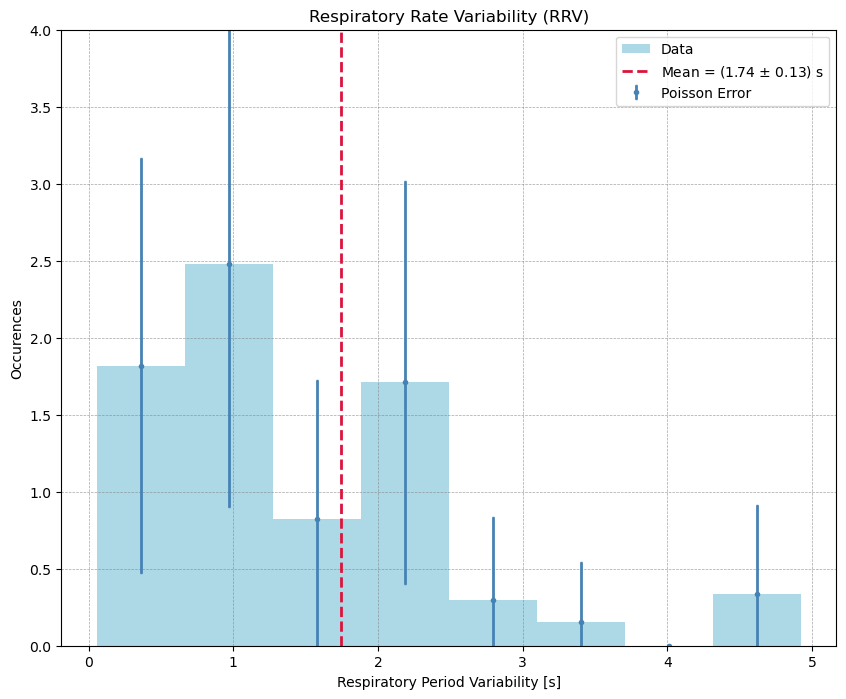

In [262]:
rrv=np.zeros(shape=len(time_dist))
rrv_set=[]
for i, x in enumerate(time_dist):
    x=np.array(x)
    rrv[i]=(np.sqrt(np.mean(np.diff(x) ** 2)))
    rrv_set.append(np.abs(np.diff(x)))

w=var_ratios[:7]
rrv_avg = np.average(rrv, weights=w)
rrv_std = np.sqrt(np.sum(w * (rrv - rrv_avg)**2) / np.sum(w * (len(rrv) - 1)))


weights = [[var_ratios[i] for j in range(len(rrv_set[i]))] for i in range(7)]
weights_total = np.concatenate(weights)
rrv_set_tot = np.concatenate(rrv_set)

plt.figure(figsize=(10, 8))
bins=plt.hist(rrv_set_tot, bins=round(np.sqrt(len(rrv_set_tot))), color='lightblue', weights=weights_total,label='Data')
bin_centers=[(bins[1][i]+bins[1][i+1])/2 for i in range(len(bins[1])-1)]
errors=np.sqrt(bins[0])

plt.errorbar(x=bin_centers, y=bins[0], yerr=errors, fmt='.', capsize=1, color='steelblue', elinewidth=2, label="Poisson Error")
plt.xlabel('Respiratory Period Variability [s]')
plt.ylabel('Occurences')
plt.title('Respiratory Rate Variability (RRV)')
plt.axvline(rrv_avg, color='crimson', linestyle='dashed', linewidth=2, label= f'Mean = ({rrv_avg:.2f} $\pm$ {(rrv_std):.2f}) s')
plt.ylim(0,4)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')


plt.legend()
plt.show()